# Sewer Environment Regression tests #

This file contains models and tests on the sewer environment data sheet. To see how the data was constructed, please look at the PMMoV IDA. This file will be mostly regression models and tests on fecal contamination marker PMMoV detection.

In [ ]:
import pandas as pd
import re
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import seaborn as sns
import statsmodels.api as sm
from scipy import stats
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from statsmodels.tsa.seasonal import seasonal_decompose

file_path = r'C:\Users\jrruh\OneDrive\Documents\Homework\Data Sciance\CSME 830\Project 2\Sewer_Env_Master.csv'

# file_path = r'C:\Users\jackz\Documents\Homework\Data Sciance\830\Project 2\Sewer_Env_Master.csv'

Sewer_env_df = pd.read_csv(file_path)
Sewer_env_df.info()



<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1141 entries, 0 to 1140
Data columns (total 20 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   Date                 1141 non-null   object 
 1   Code                 1141 non-null   object 
 2   Mean CT              1132 non-null   float64
 3   PMMoV (gc/ 100mL)    1128 non-null   float64
 4   FlowRate (MGD)       1141 non-null   object 
 5   pH                   480 non-null    float64
 6   N1                   1141 non-null   float64
 7   N2                   1141 non-null   float64
 8   Pi6                  1100 non-null   float64
 9   PRCP (Rain fall in)  1141 non-null   float64
 10  SNOW                 1141 non-null   float64
 11  SNWD (Snow Depth)    1141 non-null   int64  
 12  Discharge (ft^3/s)   1141 non-null   int64  
 13  Temp                 1141 non-null   float64
 14  sample type          1120 non-null   object 
 15  pellet volume ml     1139 non-null   f

In [2]:
Sewer_env_df['Date'] = pd.to_datetime(Sewer_env_df['Date'])

# Define the date range to remove (start and end dates)
start_date = '2022-1-01'  # Example start date
end_date = '2023-3-01'    # Example end date

# Filter the DataFrame to exclude rows within the specified date range
df_filtered = Sewer_env_df[(Sewer_env_df['Date'] < start_date) | (Sewer_env_df['Date'] > end_date)]


There are a few models we can use on the data.

- Liner regression
    - univariate regression: The best model uses only a single variable.
    - mutiverible regression: The best model uses two or more variables.

- Global vs local regression
    - Global regression: The best model is a single model tested on all of the data. This model work on local data as well as the overall data model
    - Local regression: The best model is trained on site specific factors And only predicts the output for the testing site. 
    - Semi Global regression: The best model is a Global model but a site specify consent is needed for the global model to fit at the local level

-

# Univariate regression #
Below are the models tested by liner regression with a single variable. These regression models are the simplest, but are predicted to be to simple for this problem. The Goal is to see how well each variable can fit the data on its own to get an idea for what variables might have a grater impact on the data later on.
* The liner regression models are best described using the following equation.
$$ y = w_1x + w_0 $$
where...
* y = PMMoV detected
* x = Independent variable (Temperature, Flow rate, Sediment recovery, pH)
* w = variable wights
We will plug our regression model into the least squares loss function to minimize the residuals of the model. The loss function with our model looks like...
$$ L = \sum^n_{t=1} (y_t - (w_1x_t + w_0))^2 $$
where
* y = PMMoV detected at time t
* x = Independent variable at time t
* w = variable wights
* t = time
* L = Squared sum of residuals
We can summarize the loss function model using matrixes
$$ Y = XW + \epsilon   $$
* Y = vector of Y values
* X = matrix of X values
* W = vector of weights
* $\epsilon$ = vector of residuals

We have 4 variables we can test on local data for now; Temperature, Flow rate, Sediment recovery, pH.
I will use two sites for now to for model testing, CS and WB

In [3]:
# split the data into groups for local analysis
splits = list(df_filtered.groupby("Code")) 
  
# # view splitted dataframe 
# print(splits[5][1])

# CS
CS_df = splits[0][1]
CS_df = CS_df.reset_index()
CS_df = CS_df.drop(columns = ['index'])

# GG
GG_df = splits[1][1]
GG_df = GG_df.reset_index()
GG_df = GG_df.drop(columns = ['index'])

# GO
GO_df = splits[2][1]
GO_df = GO_df.reset_index()
GO_df = GO_df.drop(columns = ['index'])

# GR
GR_df = splits[3][1]
GR_df = GR_df.reset_index()
GR_df = GR_df.drop(columns = ['index'])

# WB
WB_df = splits[4][1]
WB_df = WB_df.reset_index()
WB_df = WB_df.drop(columns = ['index'])

# WK
WK_df = splits[5][1]
WK_df = WK_df.reset_index()
WK_df = WK_df.drop(columns = ['index'])

# WY
WY_df = splits[6][1]
WY_df = WY_df.reset_index()
WY_df = WY_df.drop(columns = ['index'])

local_dfs = [CS_df,GG_df, GO_df, GR_df, WB_df, WK_df, WY_df]
local_dfs[1]

Date Code    Mean CT  PMMoV (gc/ 100mL) FlowRate (MGD)  pH  \
0   2023-03-02   GG  28.867000         215000.000          3.154 NaN   
1   2023-03-06   GG  27.144000        5480000.000           3.14 NaN   
2   2023-03-13   GG  27.100000        4690000.000          2.498 NaN   
3   2023-03-20   GG  27.129000         857000.000            1.8 NaN   
4   2023-04-03   GG  28.785000        1716828.741         4.1991 NaN   
..         ...  ...        ...                ...            ...  ..   
148 2024-10-10   GG  28.869354        2110000.000         1.6002 NaN   
149 2024-10-14   GG  26.179660        5780000.000          1.826 NaN   
150 2024-10-17   GG  28.400034        2000000.000         1.8363 NaN   
151 2024-10-21   GG  28.270570        2540000.000         1.8108 NaN   
152 2024-10-24   GG  27.809560        3260000.000         1.7868 NaN   

              N1           N2            Pi6  PRCP (Rain fall in)  SNOW  \
0    2314.666667  1792.000000    7466.666667                 0.00   0.0   
1    4460.800000  3300.266667   38624.000000                 0.41   1.5   
2    2368.000000  2816.000000   74240.000000                 0.18   2.2   
3    1670.400000  1468.800000  214848.000000                 0.00   0.0   
4    4492.800000  3859.200000  165312.000000                 0.00   0.0   
..           ...          ...            ...                  ...   ...   
148  1920.000000     0.000000    8363.883872                 0.00   0.0   
149  2215.590674     0.000000   18854.591930                 0.42   0.0   
150  1320.000000     0.000000    6187.561544                 0.00   0.0   
151  1536.000000     0.000000   30325.878910                 0.00   0.0   
152  3837.209320     0.000000   14015.083920                 0.00   0.0   

     SNWD (Snow Depth)  Discharge (ft^3/s)  Temp sample type  \
0                    0                9380   9.8           C   
1                    1                8410   9.9           C   
2                    2                7600   9.8           C   
3                    0                7030   9.7           C   
4                    0               12700   9.6           C   
..                 ...                 ...   ...         ...   
148                  0                1190  18.3           C   
149                  0                1460  17.2           C   
150                  0                1590  17.2           C   
151                  0                1420  17.4           C   
152                  0                1450  17.4           C   

     pellet volume ml  Extractor  qPCR Operator Date tested  Lag date  
0                 3.5         17             11         NaN       NaN  
1                 4.8          1             11         NaN       NaN  
2                 4.0          1             11         NaN       NaN  
3                 5.4         17             11         NaN       NaN  
4                 5.4          1             11         NaN       NaN  
..                ...        ...            ...         ...       ...  
148               8.0          4              4  10/11/2024       1.0  
149               3.5         10              6  10/16/2024       2.0  
150               5.5          4              4  10/18/2024       1.0  
151               6.4          6              6  10/23/2024       2.0  
152               6.0          4              4  10/28/2024       4.0  

[153 rows x 20 columns]

Predicted vs Imputed results for ['CS']:
Predicted Slope w1 = -3.1780e+06
Predicted Intercept w0 = 4.4794e+06
Person correlation r -2.5731e-01
square sum of residuals = 4.9071e+14


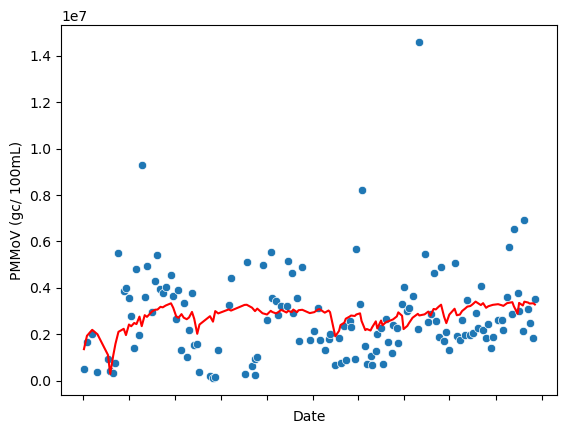

Predicted vs Imputed results for ['GG']:
Predicted Slope w1 = -7.4740e+05
Predicted Intercept w0 = 6.4419e+06
Person correlation r -1.7395e-01
square sum of residuals = 2.4892e+15


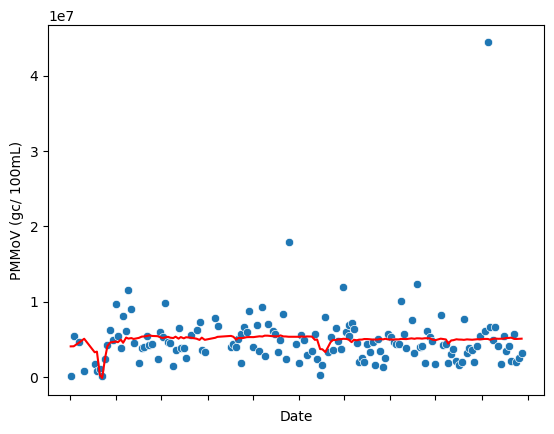

Predicted vs Imputed results for ['GO']:
Predicted Slope w1 = 1.3266e+05
Predicted Intercept w0 = 4.1526e+06
Person correlation r 9.0431e-03
square sum of residuals = 1.9790e+15


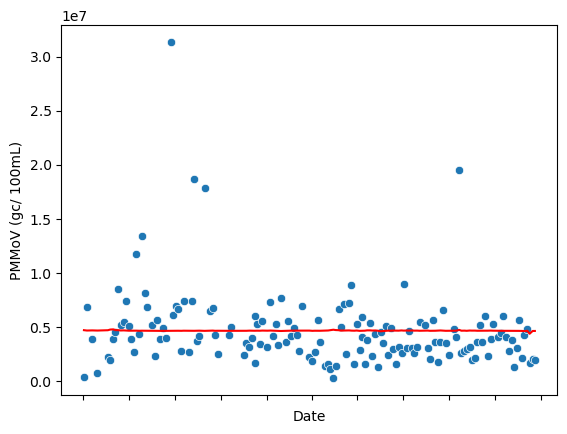

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = -8.8271e+04
Predicted Intercept w0 = 8.9149e+06
Person correlation r -2.2265e-01
square sum of residuals = 1.6123e+15


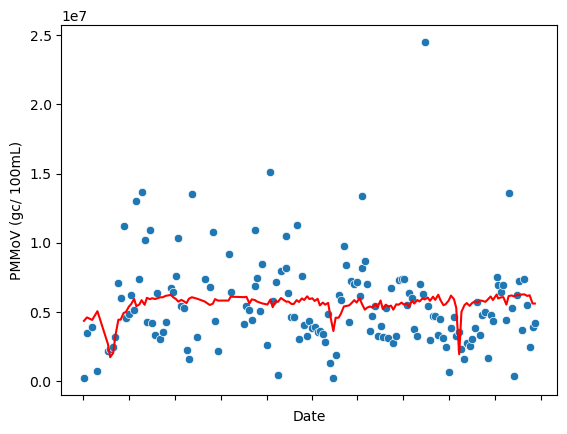

Predicted vs Imputed results for ['WB']:
Predicted Slope w1 = -2.9648e+05
Predicted Intercept w0 = 6.6828e+06
Person correlation r -1.5757e-02
square sum of residuals = 2.6734e+15


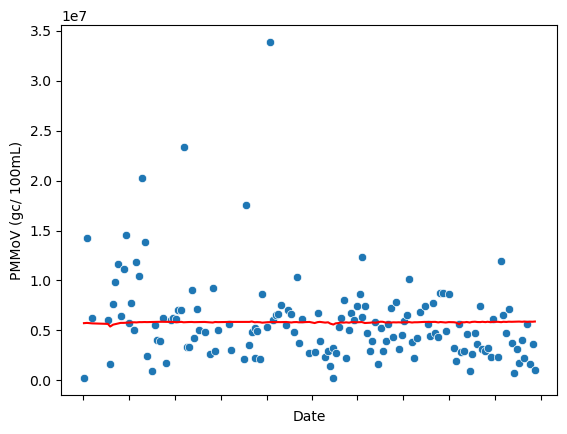

Predicted vs Imputed results for ['WK']:
Predicted Slope w1 = -1.0785e+06
Predicted Intercept w0 = 9.0404e+06
Person correlation r -6.5042e-02
square sum of residuals = 2.4315e+15


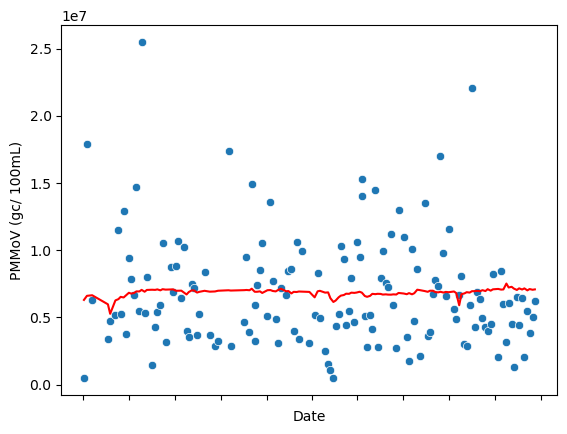

Predicted vs Imputed results for ['WY']:
Predicted Slope w1 = -4.2260e+05
Predicted Intercept w0 = 1.3248e+07
Person correlation r -1.6174e-01
square sum of residuals = 1.9031e+15


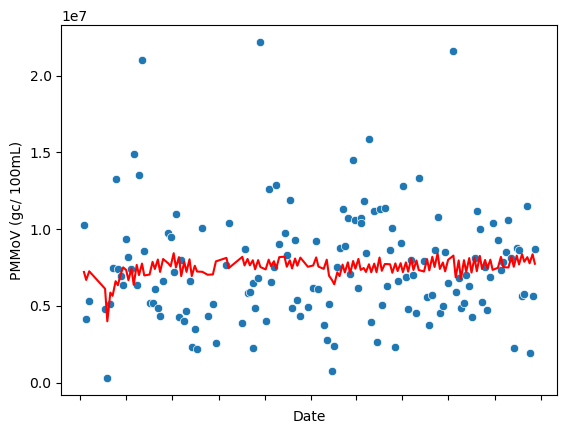

In [4]:
np.random.seed(0)
noise_level = 1

def univariate_regress(df, columnx, columny):

    if columnx not in df.columns or columny not in df.columns:
        print(f"Column {columnx} or {columny} not found in DataFrame.")
        return

    temp_df = df.dropna(subset=[f'{columnx}', f'{columny}','Date'])
    
    # Get the flow rate and discharge values as numpy arrays
    X = np.array(temp_df[f'{columnx}'])
    Y = np.array(temp_df[f'{columny}'])
    w1, w0, r, p, err = stats.linregress(X.astype(float), Y.astype(float))
    Y_predicted = w1 * temp_df[f'{columnx}'].astype(float) + w0
    residuals = ((Y - Y_predicted) ** 2).sum()

    print(f"Predicted vs Imputed results for {df['Code'].unique()}:")
    print(f"Predicted Slope w1 = {w1:.4e}")
    print(f"Predicted Intercept w0 = {w0:.4e}")
    print(f"Person correlation r {r:.4e}")
    print(f"square sum of residuals = {residuals:.4e}")
    sns.scatterplot(x=temp_df['Date'], y=temp_df[f'{columny}'], data=temp_df)
    sns.lineplot(x=temp_df['Date'], y=(Y_predicted), color = "red")
    ax = plt.gca()
    ax.set_xticklabels([])
    plt.show()

columnx = 'Mean CT'
columny = 'FlowRate (MGD)'

univariate_regress(local_dfs[0],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[1],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[2],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[3],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[4],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[5],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[6],columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')


Predicted vs Imputed results for ['CS']:
Predicted Slope w1 = 9.6048e+04
Predicted Intercept w0 = 1.3160e+06
Person correlation r 1.7476e-01
square sum of residuals = 5.0945e+14


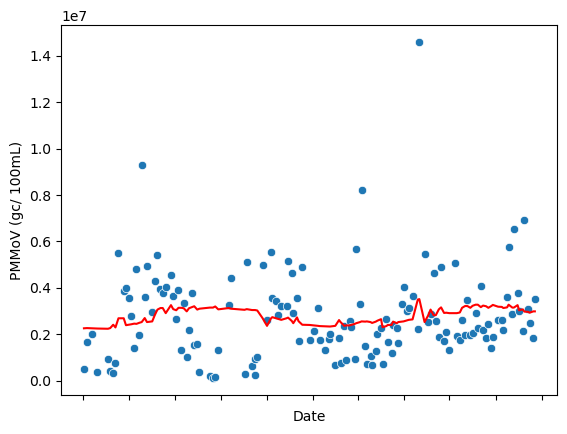

Predicted vs Imputed results for ['GG']:
Predicted Slope w1 = 1.0939e+05
Predicted Intercept w0 = 3.2741e+06
Person correlation r 9.2976e-02
square sum of residuals = 2.5447e+15


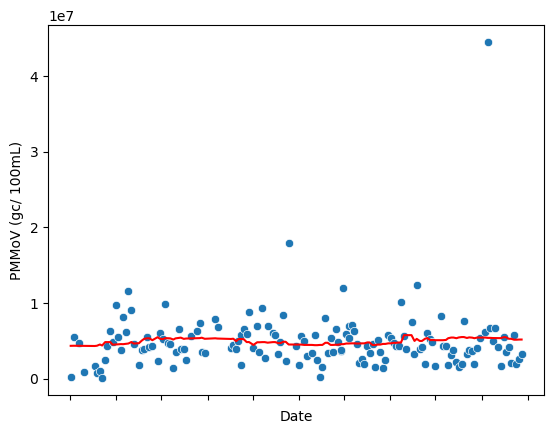

Predicted vs Imputed results for ['GO']:
Predicted Slope w1 = 1.4506e+05
Predicted Intercept w0 = 2.4397e+06
Person correlation r 1.3901e-01
square sum of residuals = 1.9409e+15


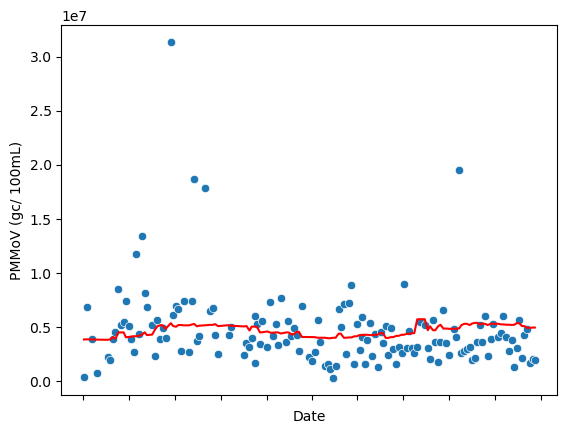

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = 1.0012e+05
Predicted Intercept w0 = 4.0371e+06
Person correlation r 1.0679e-01
square sum of residuals = 1.6771e+15


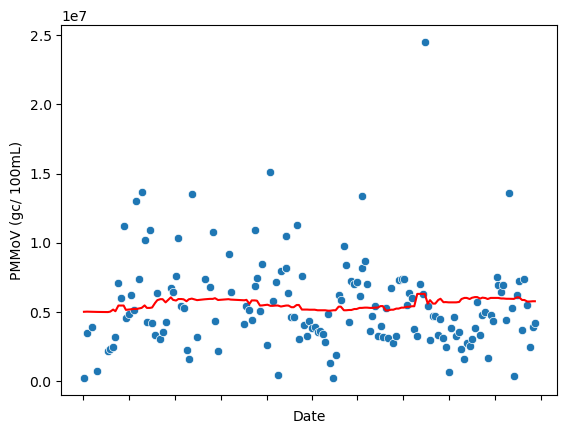

Predicted vs Imputed results for ['WB']:
Predicted Slope w1 = -1.1268e+05
Predicted Intercept w0 = 7.5408e+06
Person correlation r -9.2244e-02
square sum of residuals = 2.6513e+15


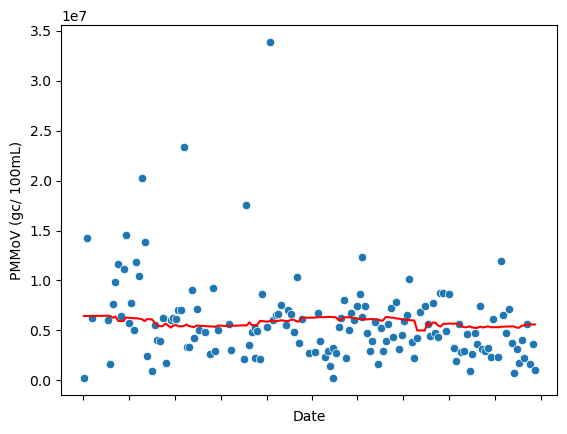

Predicted vs Imputed results for ['WK']:
Predicted Slope w1 = -3.2267e+04
Predicted Intercept w0 = 7.3549e+06
Person correlation r -2.7225e-02
square sum of residuals = 2.4400e+15


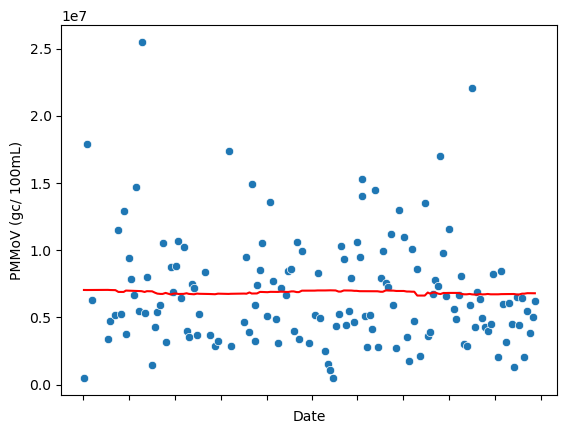

Predicted vs Imputed results for ['WY']:
Predicted Slope w1 = -7.8269e+04
Predicted Intercept w0 = 8.7306e+06
Person correlation r -7.4214e-02
square sum of residuals = 1.9434e+15


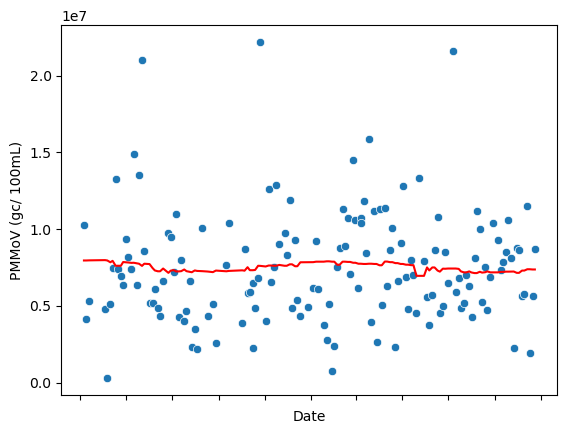

In [5]:
univariate_regress(local_dfs[0],columnx='Temp', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[1],columnx='Temp', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[2],columnx='Temp', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[3],columnx='Temp', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[4],columnx='Temp', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[5],columnx='Temp', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[6],columnx='Temp', columny='PMMoV (gc/ 100mL)')

Predicted vs Imputed results for ['CS']:
Predicted Slope w1 = 2.8032e+05
Predicted Intercept w0 = 1.3547e+06
Person correlation r 2.1651e-01
square sum of residuals = 4.9957e+14


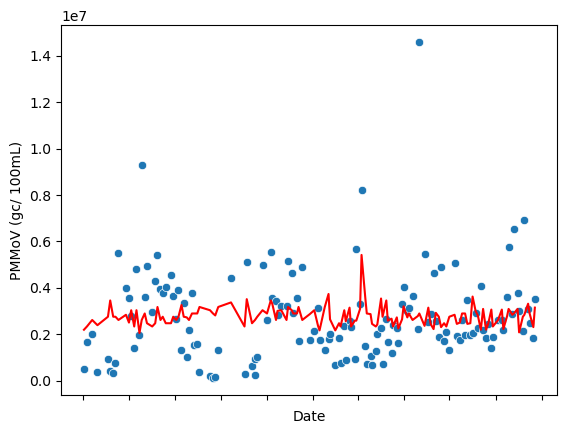

Predicted vs Imputed results for ['GG']:
Predicted Slope w1 = 3.9964e+05
Predicted Intercept w0 = 2.7026e+06
Person correlation r 2.0563e-01
square sum of residuals = 2.4584e+15


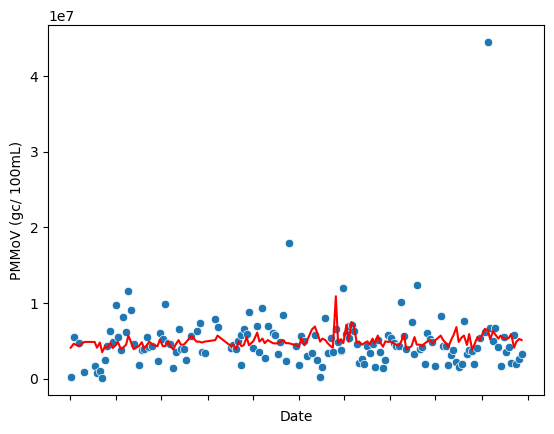

Predicted vs Imputed results for ['GO']:
Predicted Slope w1 = 1.8045e+05
Predicted Intercept w0 = 3.7302e+06
Person correlation r 6.9212e-02
square sum of residuals = 1.9697e+15


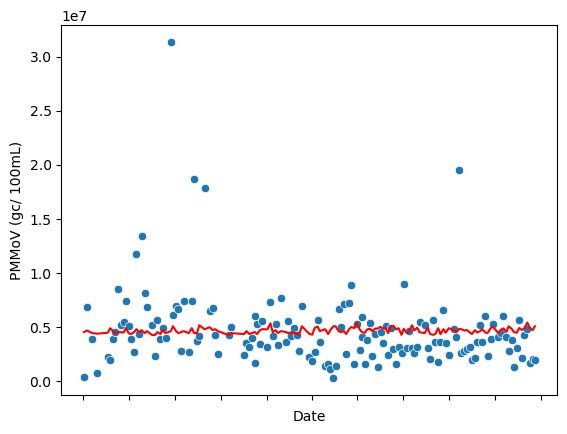

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = 5.1398e+05
Predicted Intercept w0 = 2.8710e+06
Person correlation r 2.4236e-01
square sum of residuals = 1.5968e+15


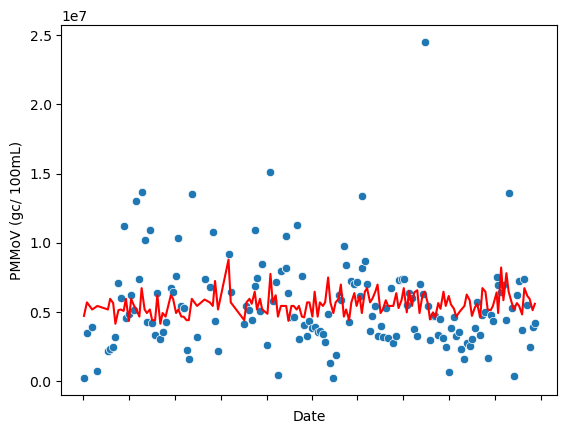

Predicted vs Imputed results for ['WB']:
Predicted Slope w1 = 1.7593e+05
Predicted Intercept w0 = 4.7182e+06
Person correlation r 7.6630e-02
square sum of residuals = 2.6584e+15


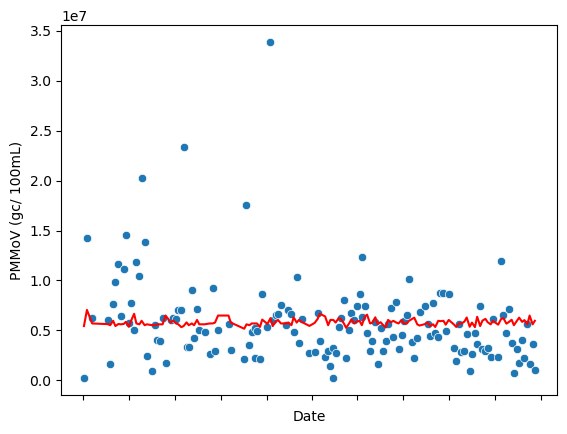

Predicted vs Imputed results for ['WK']:
Predicted Slope w1 = 2.2274e+05
Predicted Intercept w0 = 5.5179e+06
Person correlation r 1.0876e-01
square sum of residuals = 2.4130e+15


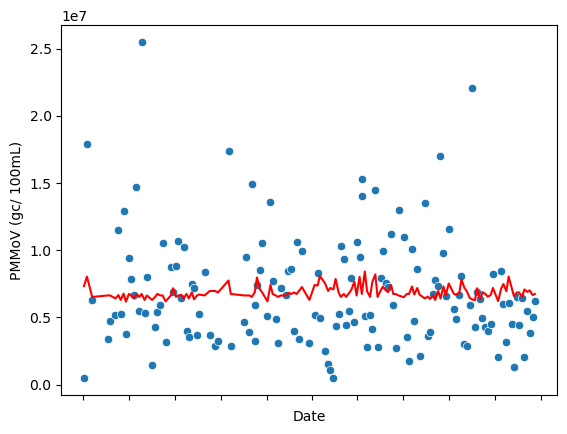

Predicted vs Imputed results for ['WY']:
Predicted Slope w1 = 2.9648e+05
Predicted Intercept w0 = 5.7407e+06
Person correlation r 1.6452e-01
square sum of residuals = 1.9013e+15


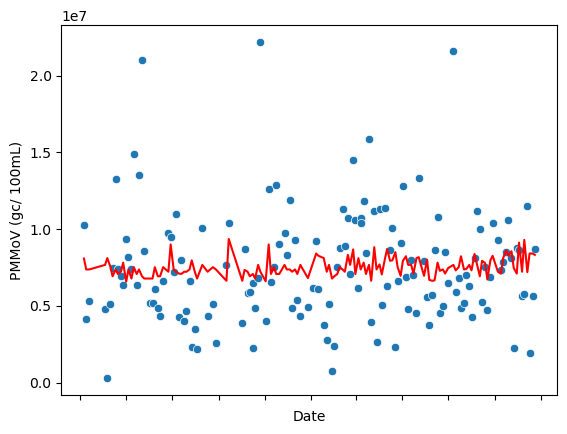

In [6]:
univariate_regress(local_dfs[0],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[1],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[2],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[3],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[4],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[5],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[6],columnx='pellet volume ml', columny='PMMoV (gc/ 100mL)')

Predicted vs Imputed results for ['CS']:
Predicted Slope w1 = -4.0292e+05
Predicted Intercept w0 = 5.6718e+06
Person correlation r -3.0005e-02
square sum of residuals = 5.2503e+14


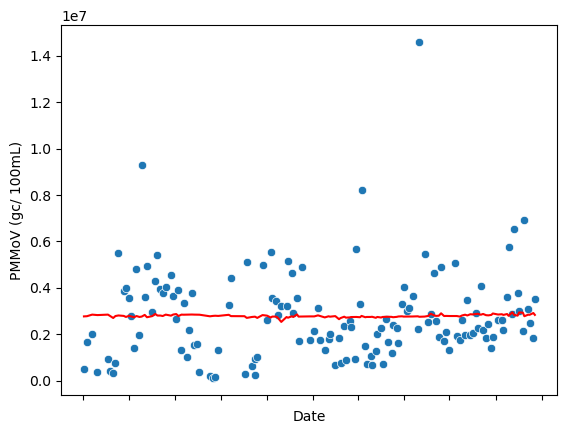

Predicted vs Imputed results for ['WB']:
Predicted Slope w1 = 1.1265e+06
Predicted Intercept w0 = -3.0774e+06
Person correlation r 6.9165e-02
square sum of residuals = 2.6613e+15


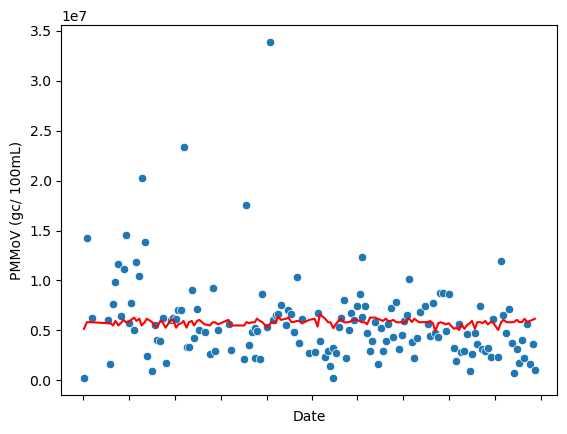

Predicted vs Imputed results for ['WK']:
Predicted Slope w1 = 2.1279e+06
Predicted Intercept w0 = -1.0170e+07
Person correlation r 1.2740e-01
square sum of residuals = 2.4022e+15


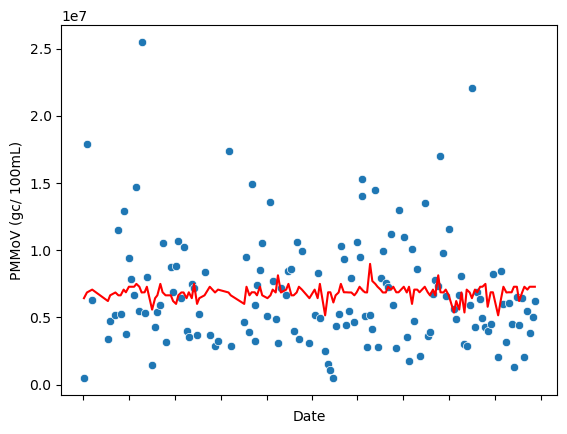

In [7]:
univariate_regress(local_dfs[0],columnx='pH', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[4],columnx='pH', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[5],columnx='pH', columny='PMMoV (gc/ 100mL)')

Predicted vs Imputed results for ['CS']:
Predicted Slope w1 = 9.5654e+04
Predicted Intercept w0 = 2.7794e+06
Person correlation r 1.8069e-02
square sum of residuals = 5.2533e+14


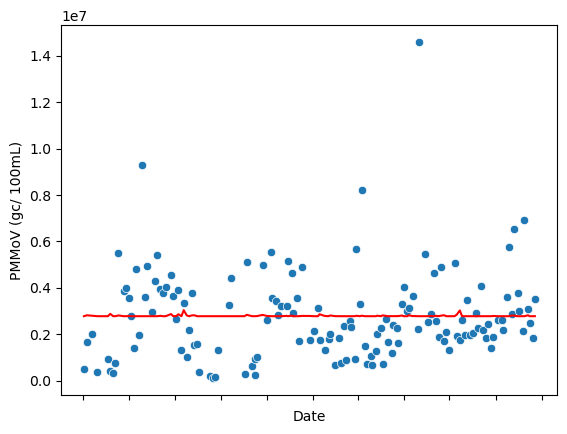

Predicted vs Imputed results for ['GG']:
Predicted Slope w1 = -2.6367e+05
Predicted Intercept w0 = 4.9865e+06
Person correlation r -2.2404e-02
square sum of residuals = 2.5656e+15


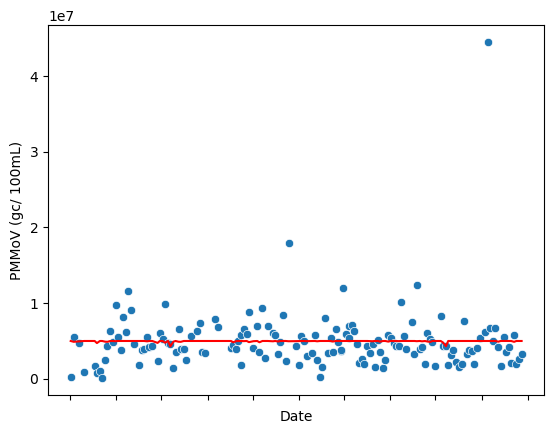

Predicted vs Imputed results for ['GO']:
Predicted Slope w1 = 4.0977e+06
Predicted Intercept w0 = 4.2021e+06
Person correlation r 3.9588e-01
square sum of residuals = 1.6690e+15


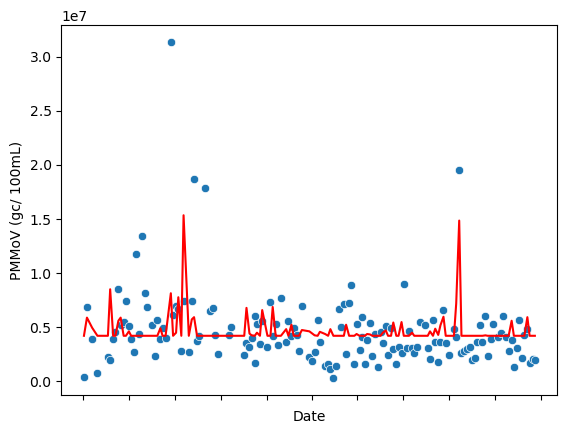

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = -1.9241e+05
Predicted Intercept w0 = 5.5946e+06
Person correlation r -2.0102e-02
square sum of residuals = 1.6957e+15


Predicted vs Imputed results for ['WB']:
Predicted Slope w1 = 2.8715e+06
Predicted Intercept w0 = 5.4617e+06
Person correlation r 2.3902e-01
square sum of residuals = 2.5213e+15


Predicted vs Imputed results for ['WK']:
Predicted Slope w1 = 1.1083e+06
Predicted Intercept w0 = 6.7232e+06
Person correlation r 9.6336e-02
square sum of residuals = 2.4192e+15


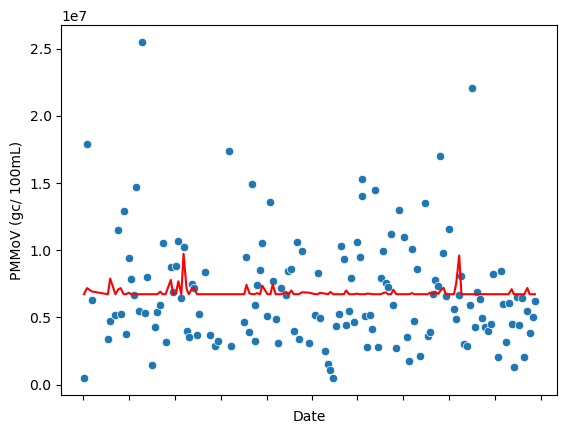

Predicted vs Imputed results for ['WY']:
Predicted Slope w1 = 2.7658e+05
Predicted Intercept w0 = 7.4872e+06
Person correlation r 2.6911e-02
square sum of residuals = 1.9528e+15


In [8]:
univariate_regress(local_dfs[0],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[1],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[2],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[3],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[4],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[5],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')
univariate_regress(local_dfs[6],columnx='PRCP (Rain fall in)', columny='PMMoV (gc/ 100mL)')

None of the single variable models seem to show much progress or insight in predicting the PMMoV values, but It looks like temperature and flow rate together could make a decent model

## mutivariate regression ##
Below are the models tested by liner regression with one or more variables. These regression models are the simple but more complex than the univarable models. The Goal is to see how well combinations of variable can fit the data.
* The mutivariable liner regression models are best described using the following equation.
$$ y = w_0 + w_1x_1 + w_2x_2 + .... + w_ix_i $$
where...
* y = PMMoV detected
* x = Independent variable (Temperature, Flow rate, Sediment recovery, pH)
* w = variable wights
We will plug our regression model into the least squares loss function to minimize the residuals of the model. The loss function with our model looks like...
$$ L = \sum^n_{t=1} (y_t - (w_0 + w_1x_1 + w_2x_2 + .... + w_ix_i))^2 $$
where
* y = PMMoV detected at time t
* x = Independent variable at time t
* w = variable wights
* t = time
* L = Squared sum of residuals
We can summarize the loss function model using matrixes
$$ Y = XW + \epsilon   $$
* Y = vector of Y values
* X = matrix of X values
* W = vector of weights
* $\epsilon$ = vector of residuals

We will not test all variable combinations but will use the univariable fits to make guesses on what variable combinations to try.

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [-2916550.84249224    19808.15983651]
Predicted Intercept w0 = 4.0362e+06
sum of residuals = 4.9026e+14


Predicted vs Imputed results for ['GG']:
Predicted Slope (weights) = [-689608.36943566   52871.89566059]
Predicted Intercept w0 = 5.5143e+06
sum of residuals = 2.4845e+15


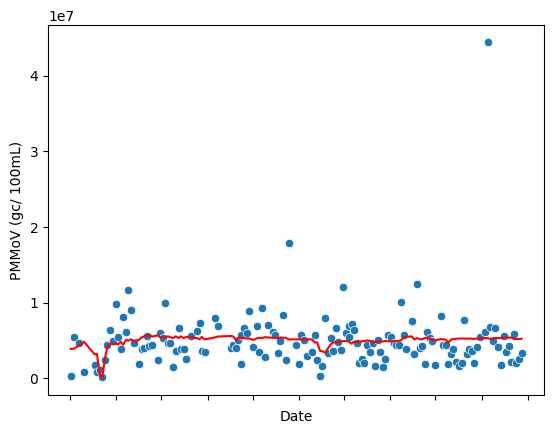

Predicted vs Imputed results for ['GO']:
Predicted Slope (weights) = [891149.97456853 165701.19590168]
Predicted Intercept w0 = -1.3870e+06
sum of residuals = 1.9344e+15


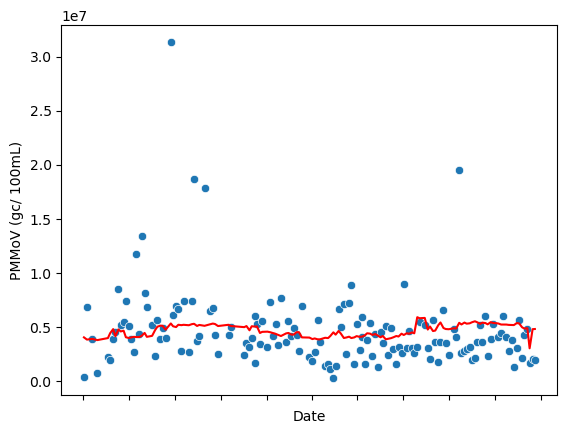

Predicted vs Imputed results for ['GR']:
Predicted Slope (weights) = [-85794.29193167  13760.45882335]
Predicted Intercept w0 = 8.6100e+06
sum of residuals = 1.6120e+15


Predicted vs Imputed results for ['WB']:
Predicted Slope (weights) = [-1671656.53885879  -169757.69263057]
Predicted Intercept w0 = 1.3406e+07
sum of residuals = 2.6360e+15


Predicted vs Imputed results for ['WK']:
Predicted Slope (weights) = [-1919235.22876944  -108346.6142505 ]
Predicted Intercept w0 = 1.2424e+07
sum of residuals = 2.4174e+15


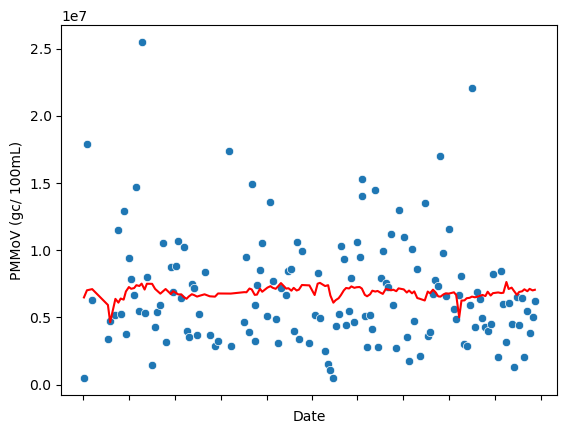

Predicted vs Imputed results for ['WY']:
Predicted Slope (weights) = [-543847.59136326 -149924.54793966]
Predicted Intercept w0 = 1.7210e+07
sum of residuals = 1.8678e+15


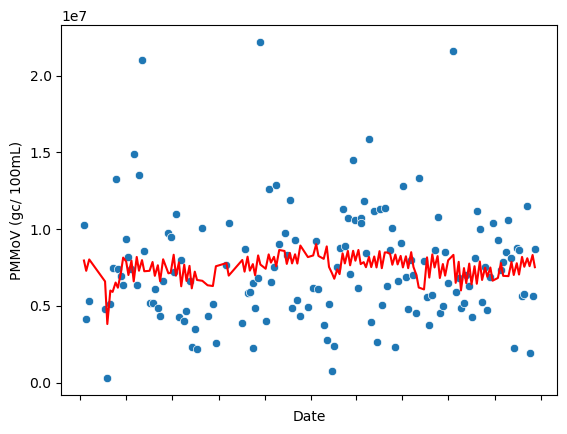

In [9]:
def mutivariate_regress(df, columnx, columny):

    if not all(col in df.columns for col in columnx) or columny not in df.columns:
        print(f"One or more columns from {columnx} or {columny} not found in DataFrame.")
        return

    temp_df = df.dropna(subset=columnx + [columny, 'Date'])
    
    # Get the flow rate and discharge values as numpy arrays
    X = temp_df[columnx].values
    Y = temp_df[columny].values

    model = LinearRegression()
    model.fit(X, Y)

    Y_predicted = model.predict(X)
    residuals = ((Y - Y_predicted) ** 2).sum()

    print(f"Predicted vs Imputed results for {df['Code'].unique()}:")
    print(f"Predicted Slope (weights) = {model.coef_}")
    print(f"Predicted Intercept w0 = {model.intercept_:.4e}")
    print(f"sum of residuals = {residuals:.4e}")
    
    sns.scatterplot(x=temp_df['Date'], y=temp_df[f'{columny}'], data=temp_df)
    sns.lineplot(x=temp_df['Date'], y=(Y_predicted), color = "red")
    ax = plt.gca()
    ax.set_xticklabels([])
    plt.show()

mutivariate_regress(local_dfs[0],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[1],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[2],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[3],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[4],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[5],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[6],columnx=['FlowRate (MGD)','Temp'], columny='PMMoV (gc/ 100mL)')

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [-2983205.81973167    17067.72802148   179778.8133453 ]
Predicted Intercept w0 = 4.0900e+06
sum of residuals = 4.8967e+14


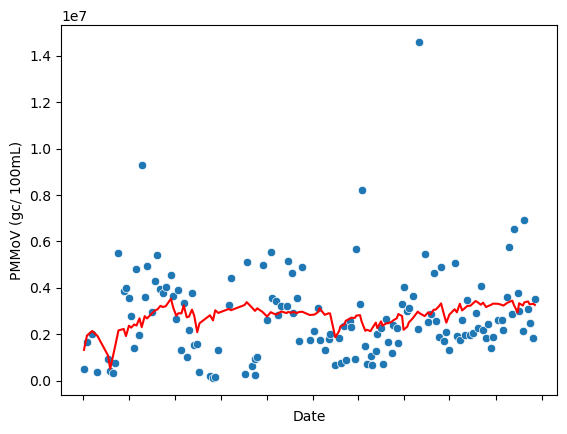

Predicted vs Imputed results for ['GG']:
Predicted Slope (weights) = [-688184.15803097   55322.7596443  -323612.09674459]
Predicted Intercept w0 = 5.5116e+06
sum of residuals = 2.4826e+15


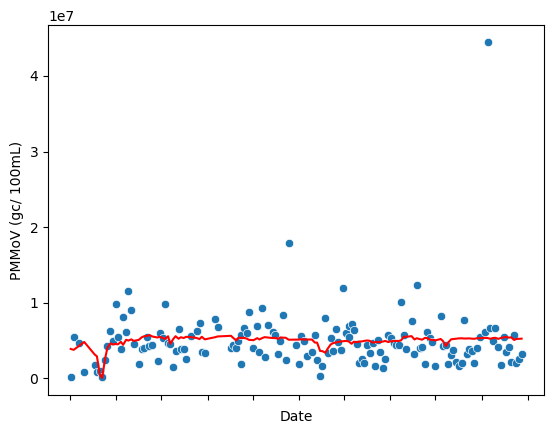

Predicted vs Imputed results for ['GO']:
Predicted Slope (weights) = [-365664.30214732  108712.1193404  4068933.80766731]
Predicted Intercept w0 = 3.9699e+06
sum of residuals = 1.6430e+15


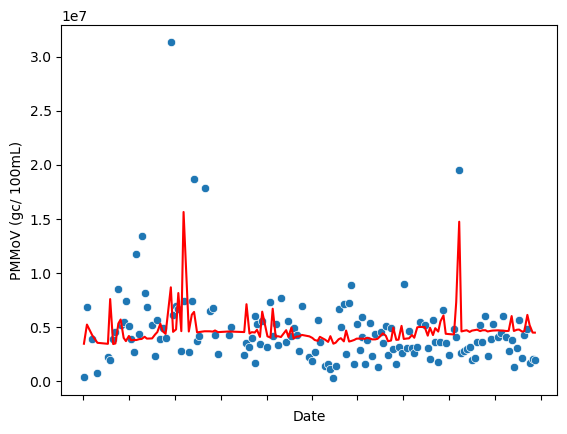

Predicted vs Imputed results for ['GR']:
Predicted Slope (weights) = [-9.52269480e+04  5.19274408e+02  5.36522877e+05]
Predicted Intercept w0 = 9.1093e+06
sum of residuals = 1.6075e+15


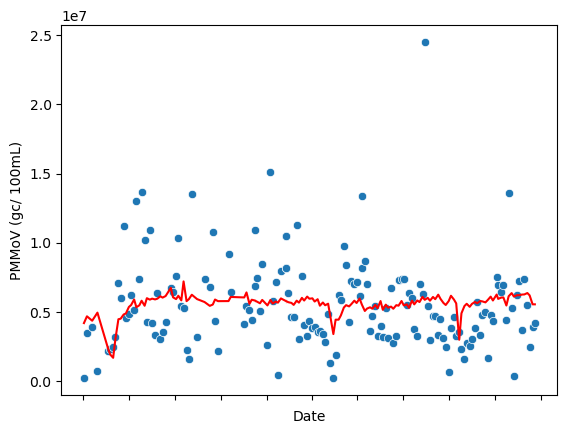

Predicted vs Imputed results for ['WB']:
Predicted Slope (weights) = [-3924322.02469375  -272340.6563719   3674440.24650319]
Predicted Intercept w0 = 2.1275e+07
sum of residuals = 2.4148e+15


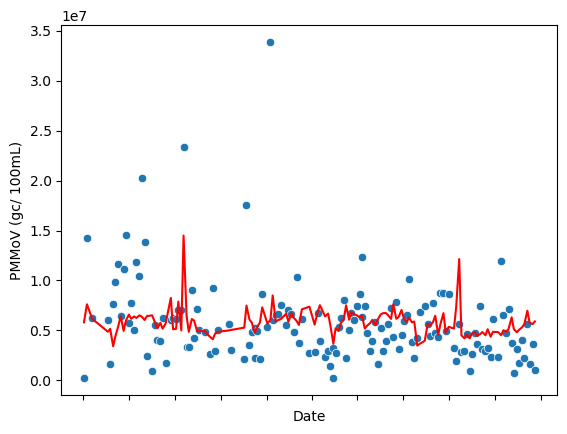

Predicted vs Imputed results for ['WK']:
Predicted Slope (weights) = [-3164899.8189512   -171046.81921814  1849617.30253545]
Predicted Intercept w0 = 1.5702e+07
sum of residuals = 2.3641e+15


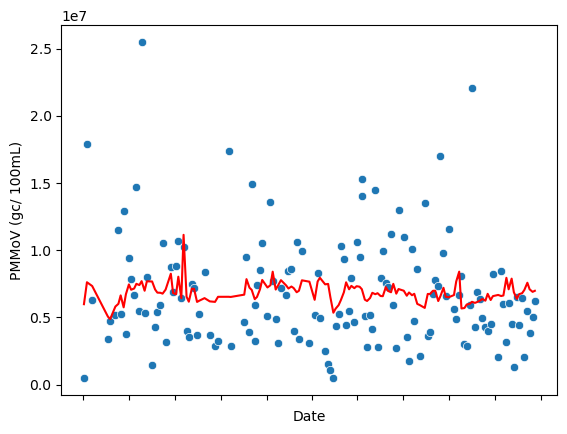

Predicted vs Imputed results for ['WY']:
Predicted Slope (weights) = [-576045.85504936 -159099.69314304  699081.594677  ]
Predicted Intercept w0 = 1.7705e+07
sum of residuals = 1.8590e+15


In [10]:
mutivariate_regress(local_dfs[0],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[1],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[2],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[3],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[4],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[5],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[6],columnx=['FlowRate (MGD)','Temp','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)')

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [-3122328.24851146    12414.38092115   283271.1684445 ]
Predicted Intercept w0 = 2.8050e+06
sum of residuals = 4.6261e+14


Predicted vs Imputed results for ['GG']:
Predicted Slope (weights) = [-585471.35367167   56543.21298265  364699.06485701]
Predicted Intercept w0 = 3.1947e+06
sum of residuals = 2.3955e+15


Predicted vs Imputed results for ['GO']:
Predicted Slope (weights) = [936464.17482284 171138.21157309 206120.96742576]
Predicted Intercept w0 = -2.7283e+06
sum of residuals = 1.9221e+15


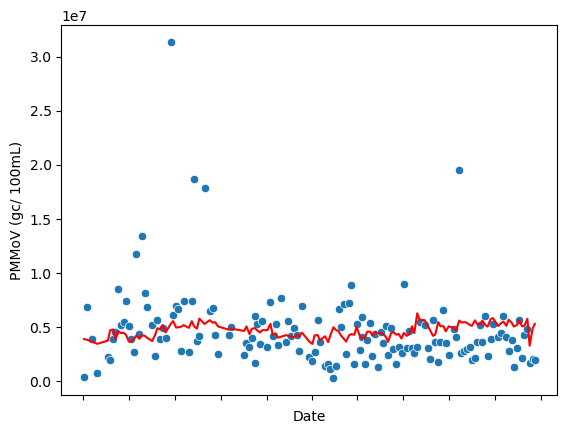

Predicted vs Imputed results for ['GR']:
Predicted Slope (weights) = [-82411.63614926  -7585.05413971 480525.50350638]
Predicted Intercept w0 = 6.2834e+06
sum of residuals = 1.5262e+15


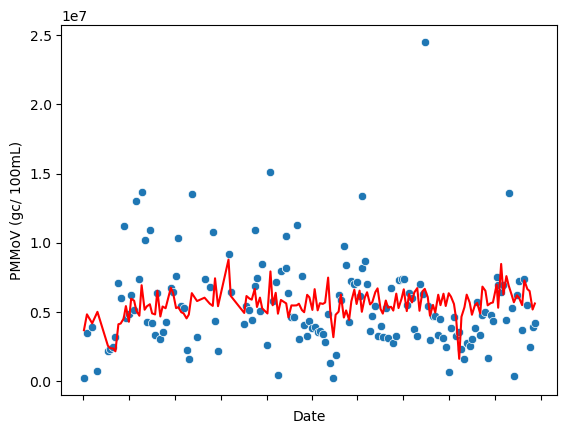

Predicted vs Imputed results for ['WB']:
Predicted Slope (weights) = [-1604151.07660652  -159200.65635849   147358.43160075]
Predicted Intercept w0 = 1.2136e+07
sum of residuals = 2.6252e+15


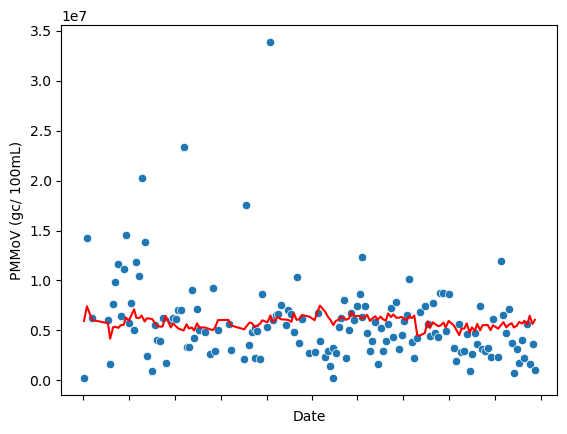

Predicted vs Imputed results for ['WK']:
Predicted Slope (weights) = [-1913176.75196764   -89644.67967913   218695.9069626 ]
Predicted Intercept w0 = 1.0809e+07
sum of residuals = 2.3901e+15


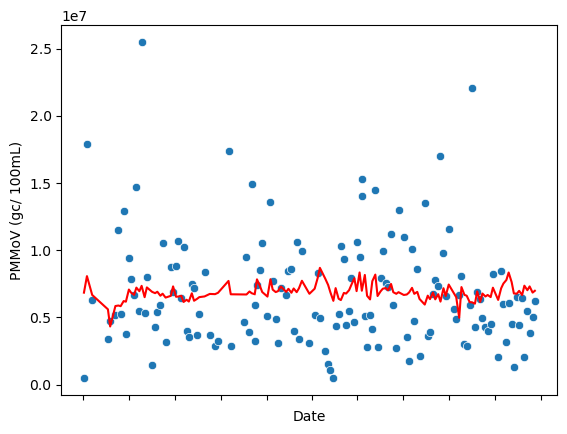

Predicted vs Imputed results for ['WY']:
Predicted Slope (weights) = [-502178.86752444 -148946.84314682  267288.40947739]
Predicted Intercept w0 = 1.5026e+07
sum of residuals = 1.8253e+15


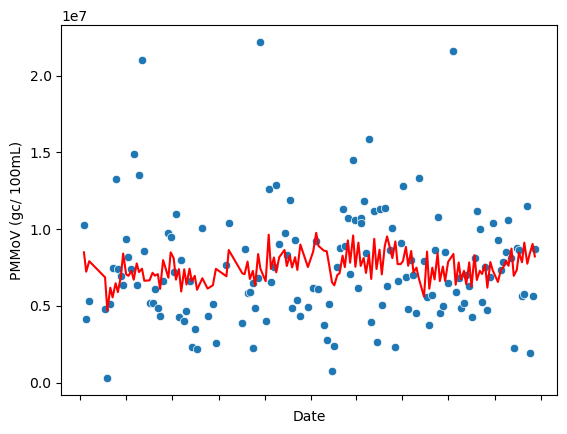

In [11]:
mutivariate_regress(local_dfs[0],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[1],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[2],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[3],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[4],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[5],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[6],columnx=['FlowRate (MGD)','Temp','pellet volume ml'], columny='PMMoV (gc/ 100mL)')

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [-3125075.39739819    26832.90702995   276069.12410867   694520.44966523]
Predicted Intercept w0 = -2.3427e+06
sum of residuals = 4.6159e+14


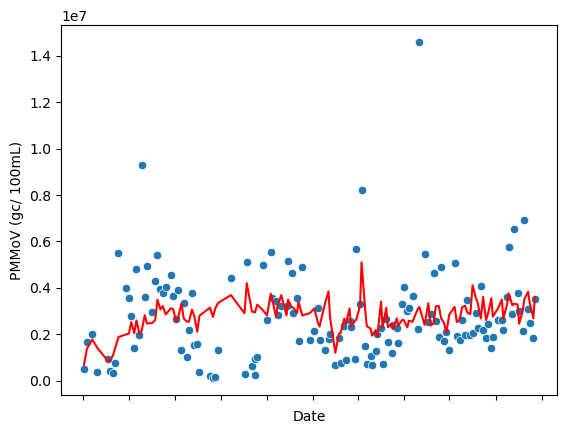

Predicted vs Imputed results for ['WB']:
Predicted Slope (weights) = [-1467991.99631128  -150652.10185413   139794.42283093   307288.85032231]
Predicted Intercept w0 = 9.2235e+06
sum of residuals = 2.6244e+15


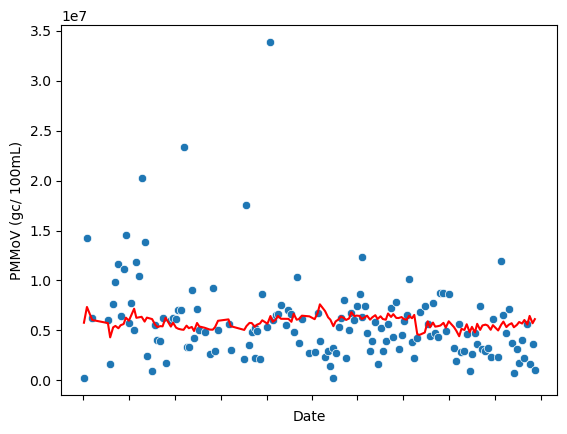

Predicted vs Imputed results for ['WK']:
Predicted Slope (weights) = [-1548388.13790954   -64016.79901675   213503.09870771  1847380.1727378 ]
Predicted Intercept w0 = -5.0763e+06
sum of residuals = 2.3613e+15


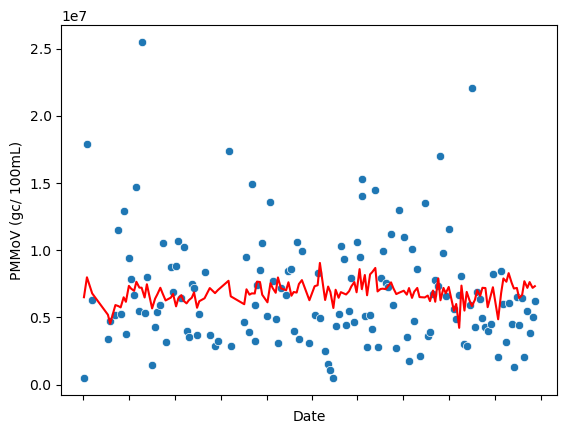

In [12]:
mutivariate_regress(local_dfs[0],columnx=['FlowRate (MGD)','Temp','pellet volume ml','pH'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[4],columnx=['FlowRate (MGD)','Temp','pellet volume ml','pH'], columny='PMMoV (gc/ 100mL)')
mutivariate_regress(local_dfs[5],columnx=['FlowRate (MGD)','Temp','pellet volume ml','pH'], columny='PMMoV (gc/ 100mL)')

None of the variables seem to work very well at predicting changes in PMMoV, I believe its more likely that recovery PMMoV may not be liner but maybe its logarithmic. What if a change in the environment. I also suspect the early points on the graph are trial point, where data was recorded but the method of detection was still being refined.

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [-0.85627019]
Predicted Intercept w0 = 6.7887e+00
sum of residuals = 1.5245e+01


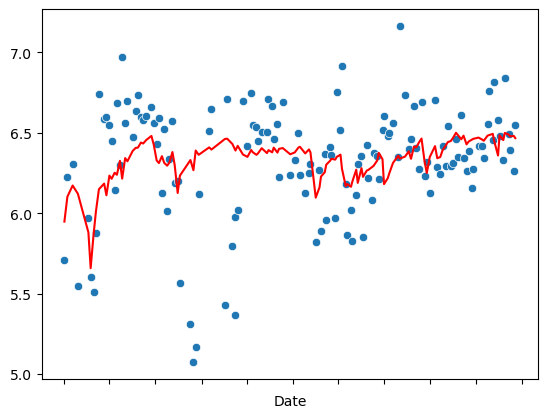

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [-0.86948987  0.07797499]
Predicted Intercept w0 = 6.7855e+00
sum of residuals = 1.5132e+01


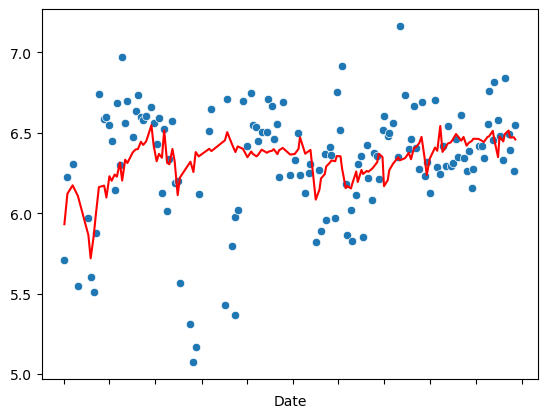

In [13]:
def logmutivariate_regress(df, columnx, columny, a=None):

    if not all(col in df.columns for col in columnx) or columny not in df.columns:
        print(f"One or more columns from {columnx} or {columny} not found in DataFrame.")
        return

    temp_df = df.dropna(subset=columnx + [columny, 'Date'])
    
    # Get the flow rate and discharge values as numpy arrays
    X = temp_df[columnx].values
    Y = temp_df[columny].values

    if a is not None:
        # Apply log(a) transformation to X
        Y = np.emath.logn((a + 1e-6),Y)
    
    model = LinearRegression()
    model.fit(X, Y)

    Y_predicted = model.predict(X)
    residuals = ((Y - Y_predicted) ** 2).sum()

    print(f"Predicted vs Imputed results for {df['Code'].unique()}:")
    print(f"Predicted Slope (weights) = {model.coef_}")
    print(f"Predicted Intercept w0 = {model.intercept_:.4e}")
    print(f"sum of residuals = {residuals:.4e}")
    
    sns.scatterplot(x=temp_df['Date'], y=Y, data=temp_df)
    sns.lineplot(x=temp_df['Date'], y=(Y_predicted), color = "red")
    ax = plt.gca()
    ax.set_xticklabels([])
    plt.show()

a = 10

logmutivariate_regress(local_dfs[0],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[0],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

Predicted vs Imputed results for ['GG']:
Predicted Slope (weights) = [-0.16023888]
Predicted Intercept w0 = 6.9195e+00
sum of residuals = 1.1261e+01


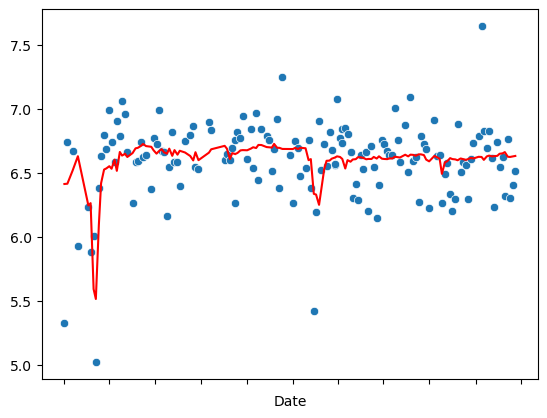

Predicted vs Imputed results for ['GG']:
Predicted Slope (weights) = [-0.16022027  0.00480065]
Predicted Intercept w0 = 6.9189e+00
sum of residuals = 1.1261e+01


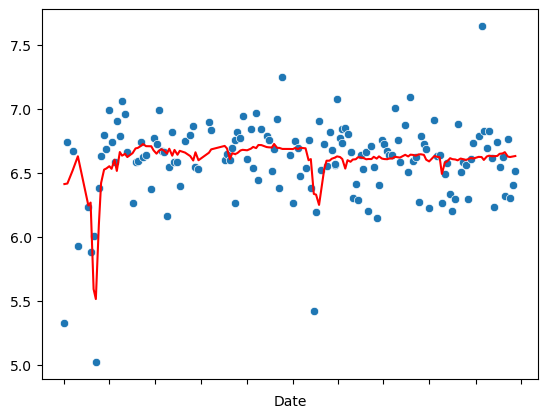

In [14]:
logmutivariate_regress(local_dfs[1],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[1],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

Predicted vs Imputed results for ['GO']:
Predicted Slope (weights) = [-0.06844707]
Predicted Intercept w0 = 6.8536e+00
sum of residuals = 1.1195e+01


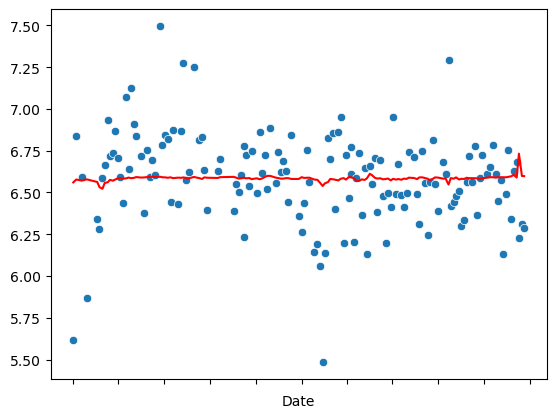

Predicted vs Imputed results for ['GO']:
Predicted Slope (weights) = [-0.12646405  0.23702769]
Predicted Intercept w0 = 7.0546e+00
sum of residuals = 1.0188e+01


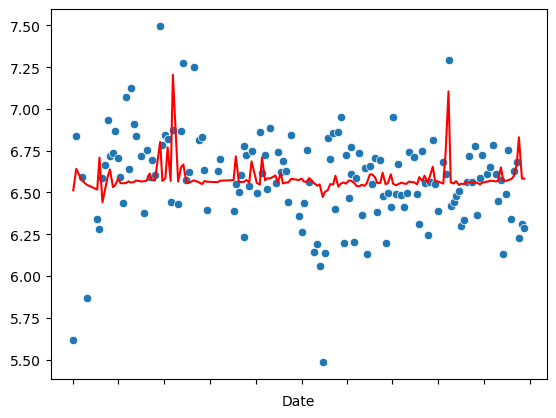

In [15]:
logmutivariate_regress(local_dfs[2],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[2],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

Predicted vs Imputed results for ['GR']:
Predicted Slope (weights) = [-0.01033604]
Predicted Intercept w0 = 7.0566e+00
sum of residuals = 1.3058e+01


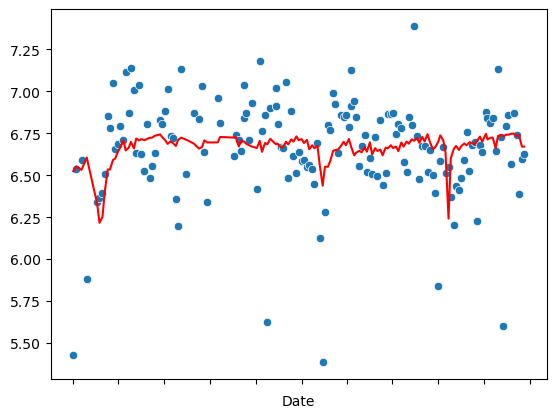

Predicted vs Imputed results for ['GR']:
Predicted Slope (weights) = [-0.01182182  0.11308648]
Predicted Intercept w0 = 7.1000e+00
sum of residuals = 1.2845e+01


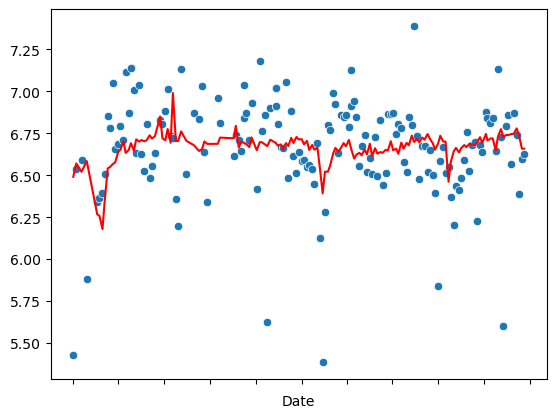

In [16]:
logmutivariate_regress(local_dfs[3],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[3],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

Predicted vs Imputed results for ['WB']:
Predicted Slope (weights) = [-0.14222685]
Predicted Intercept w0 = 7.0913e+00
sum of residuals = 1.4217e+01


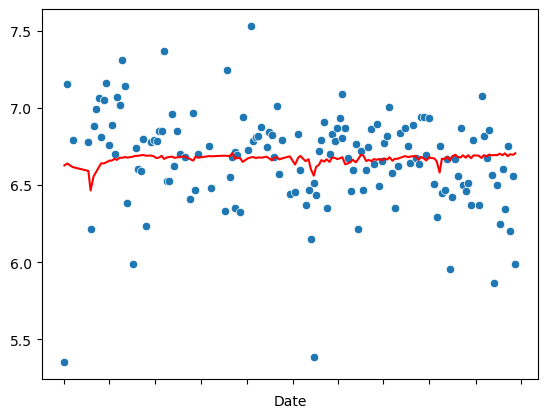

Predicted vs Imputed results for ['WB']:
Predicted Slope (weights) = [-0.21162522  0.17936805]
Predicted Intercept w0 = 7.2771e+00
sum of residuals = 1.3657e+01


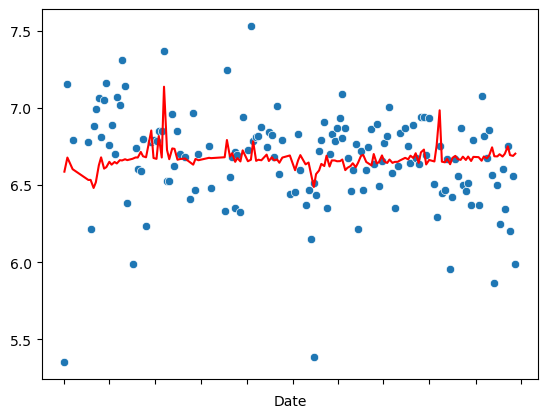

In [17]:
logmutivariate_regress(local_dfs[4],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[4],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

Predicted vs Imputed results for ['WK']:
Predicted Slope (weights) = [-0.13722607]
Predicted Intercept w0 = 7.0364e+00
sum of residuals = 1.1040e+01


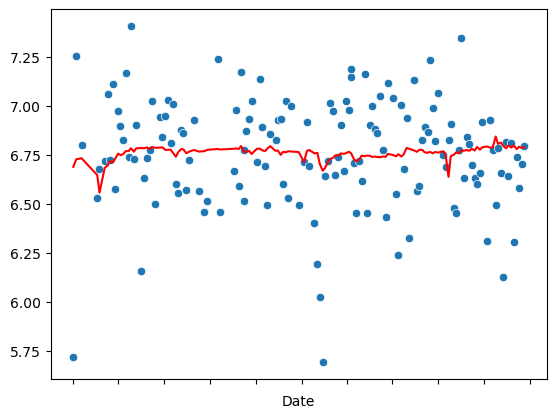

Predicted vs Imputed results for ['WK']:
Predicted Slope (weights) = [-0.19771667  0.14738322]
Predicted Intercept w0 = 7.1415e+00
sum of residuals = 1.0672e+01


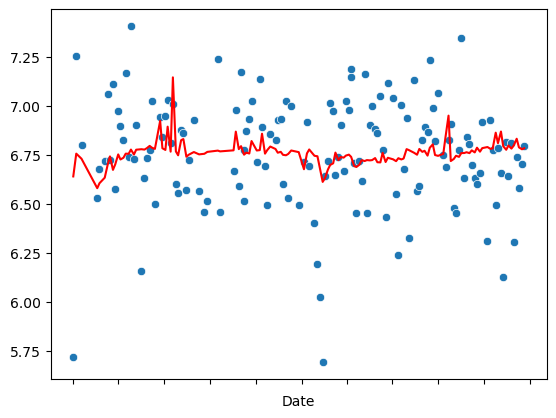

In [18]:
logmutivariate_regress(local_dfs[5],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[5],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

Predicted vs Imputed results for ['WY']:
Predicted Slope (weights) = [-0.05660302]
Predicted Intercept w0 = 7.5873e+00
sum of residuals = 7.8971e+00


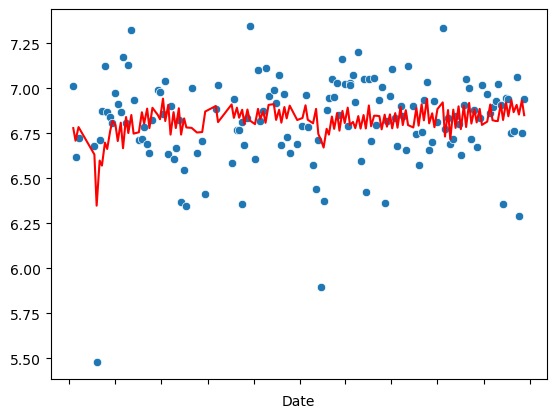

Predicted vs Imputed results for ['WY']:
Predicted Slope (weights) = [-0.05711513  0.01444854]
Predicted Intercept w0 = 7.5925e+00
sum of residuals = 7.8933e+00


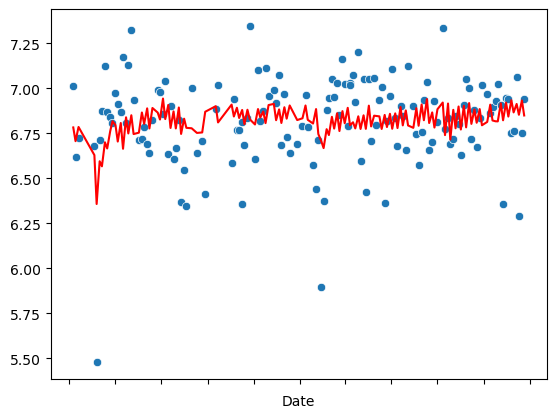

In [19]:
logmutivariate_regress(local_dfs[6],columnx=['FlowRate (MGD)',], columny='PMMoV (gc/ 100mL)', a=a)
logmutivariate_regress(local_dfs[6],columnx=['FlowRate (MGD)','PRCP (Rain fall in)'], columny='PMMoV (gc/ 100mL)', a=a)

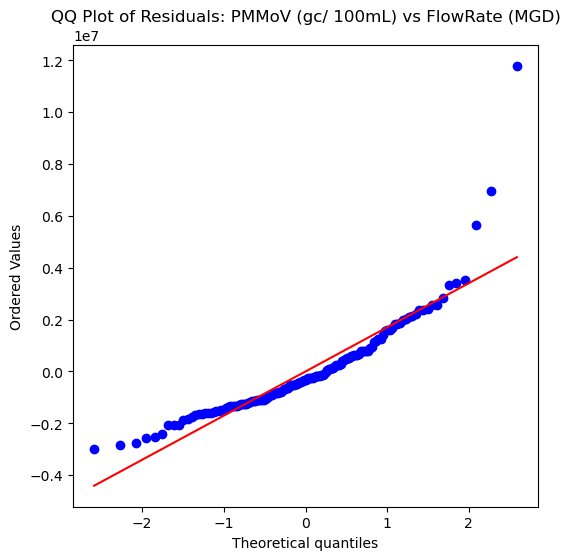

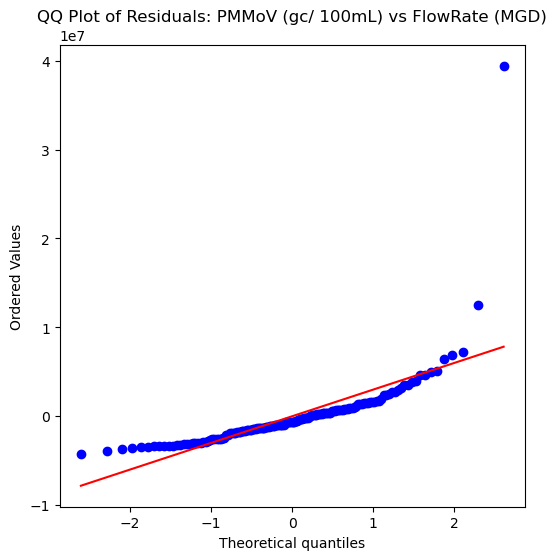

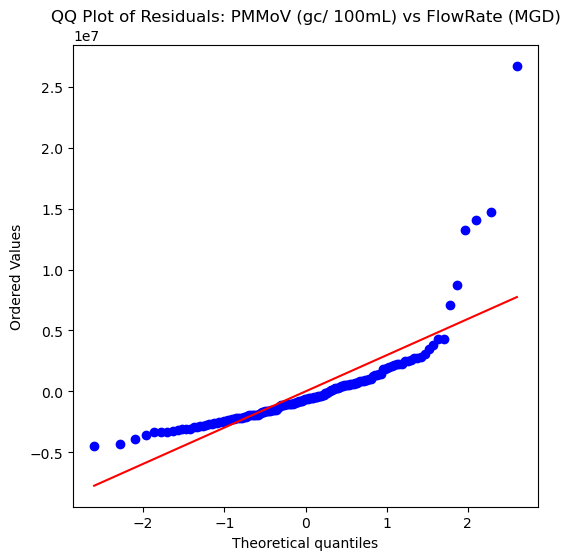

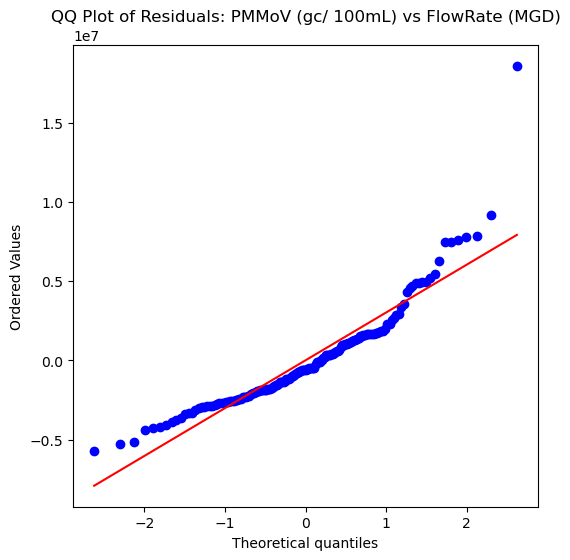

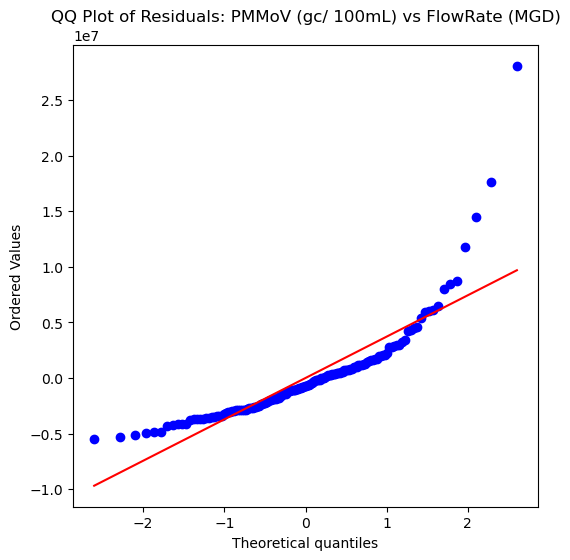

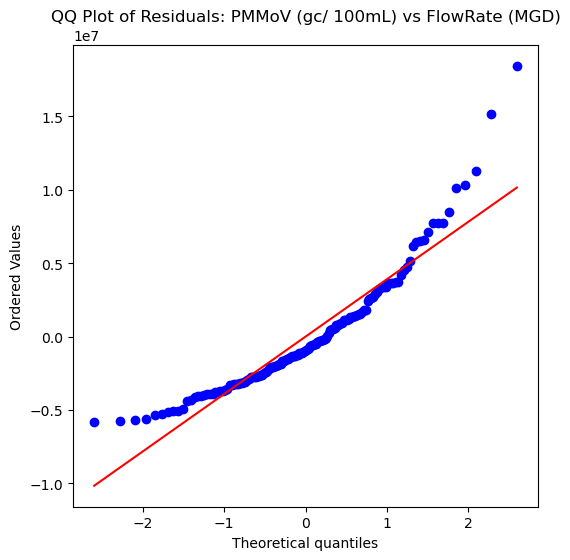

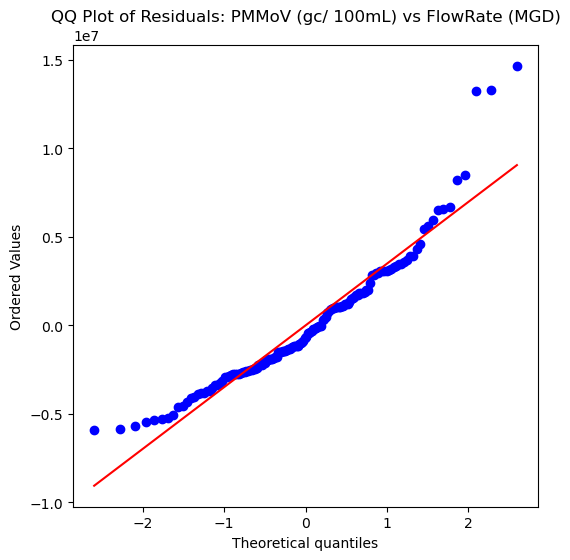

In [20]:
def QQplot_univariate(df, columnx, columny, a=None):

    if columnx not in df.columns or columny not in df.columns:
        print(f"Column {columnx} or {columny} not found in DataFrame.")
        return

    temp_df = df.dropna(subset=[f'{columnx}', f'{columny}','Date'])
    
    # Get the flow rate and discharge values as numpy arrays
    X = np.array(temp_df[f'{columnx}'])
    Y = np.array(temp_df[f'{columny}'])

    if a is not None:
        # Apply log(a) transformation to X
        Y = np.emath.logn((a + 1e-6),Y)
    
    w1, w0, r, p, err = stats.linregress(X.astype(float), Y.astype(float))
    Y_predicted = w1 * temp_df[f'{columnx}'].astype(float) + w0
    residuals = (Y - Y_predicted)

    fig = plt.figure(figsize=(6, 6))
    ax = fig.add_subplot(111)
    
    # Generate the QQ plot for the residuals
    stats.probplot(residuals, dist="norm", plot=ax)
    
    # Set plot titles and labels
    plt.title(f"QQ Plot of Residuals: {columny} vs {columnx}")
    plt.show()


QQplot_univariate(local_dfs[0], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
QQplot_univariate(local_dfs[1], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
QQplot_univariate(local_dfs[2], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
QQplot_univariate(local_dfs[3], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
QQplot_univariate(local_dfs[4], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
QQplot_univariate(local_dfs[5], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
QQplot_univariate(local_dfs[6], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')

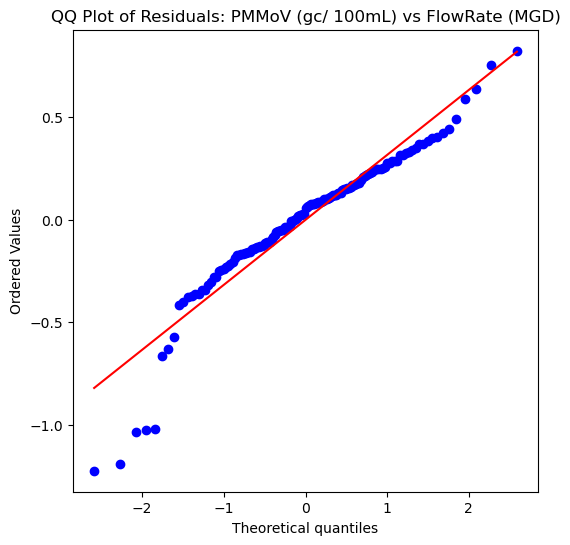

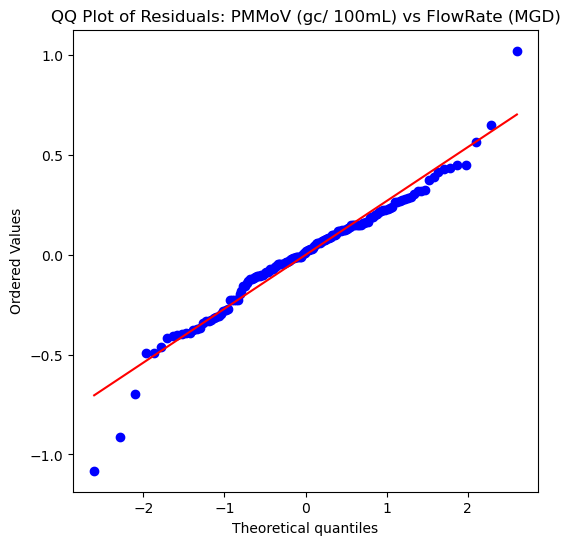

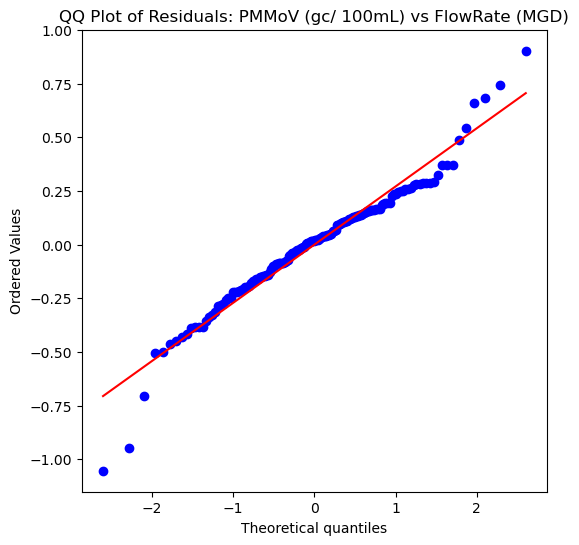

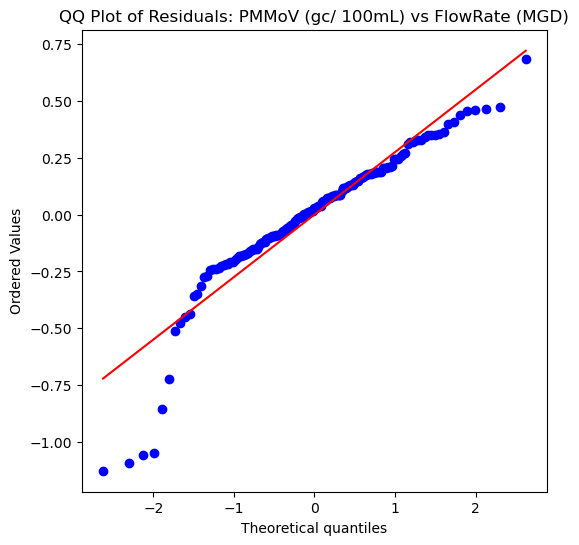

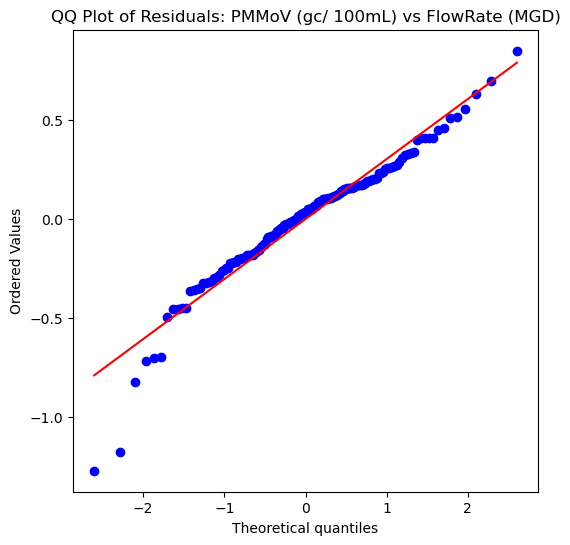

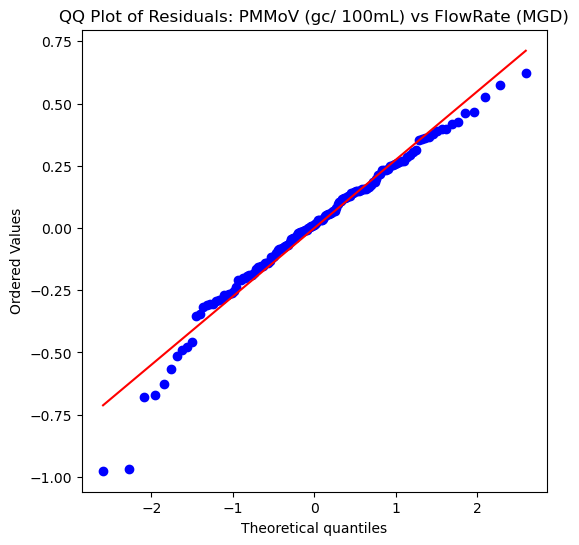

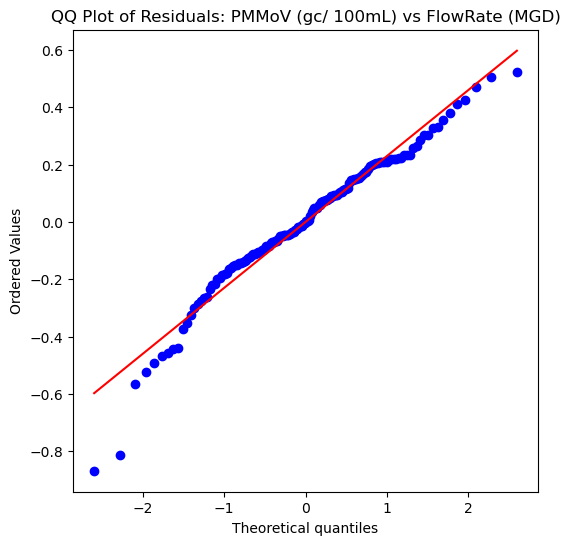

In [21]:
QQplot_univariate(local_dfs[0], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)
QQplot_univariate(local_dfs[1], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)
QQplot_univariate(local_dfs[2], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)
QQplot_univariate(local_dfs[3], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)
QQplot_univariate(local_dfs[4], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)
QQplot_univariate(local_dfs[5], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)
QQplot_univariate(local_dfs[6], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)', a=a)

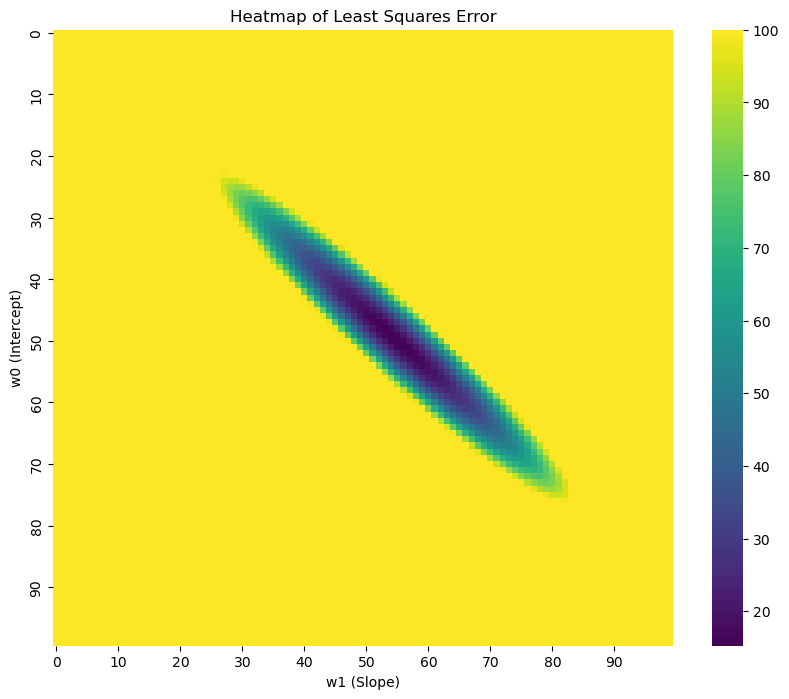

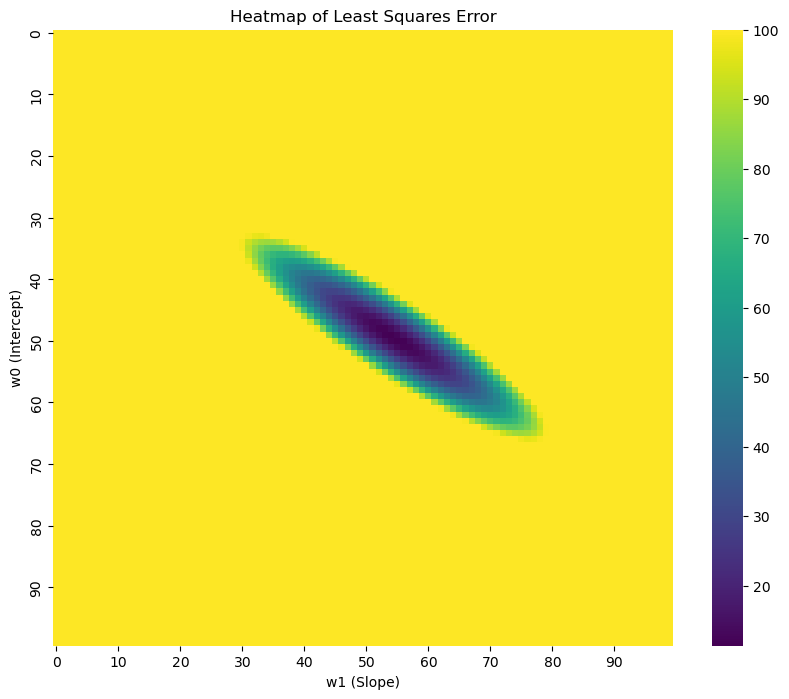

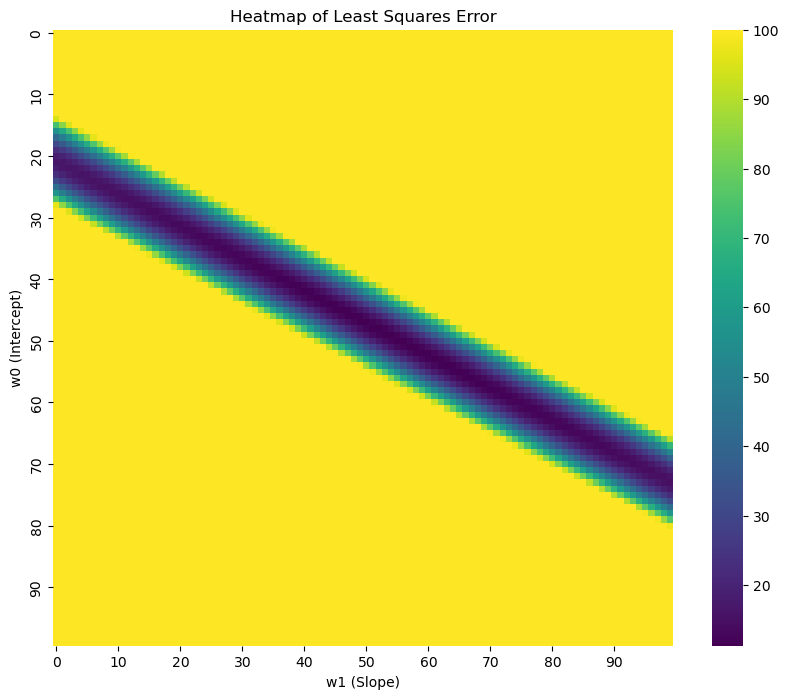

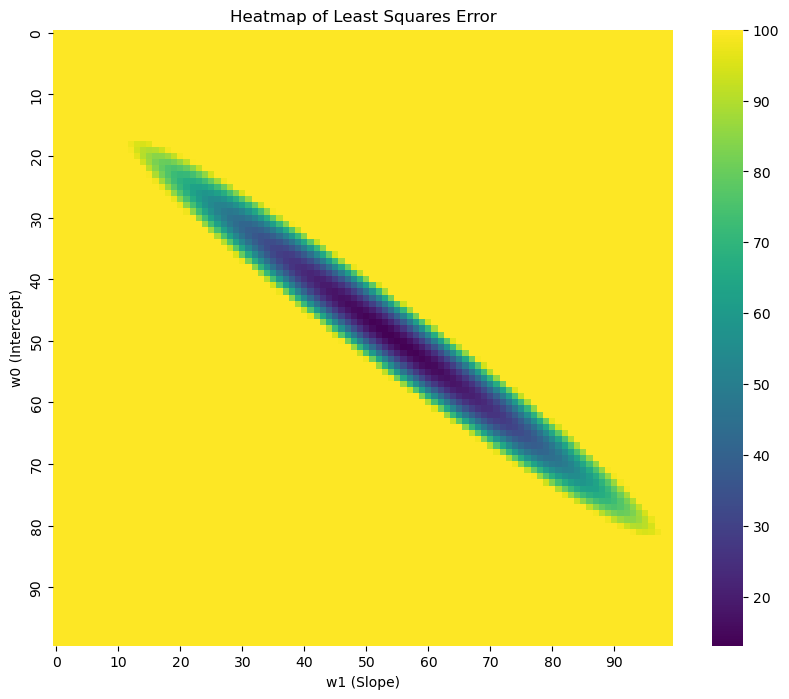

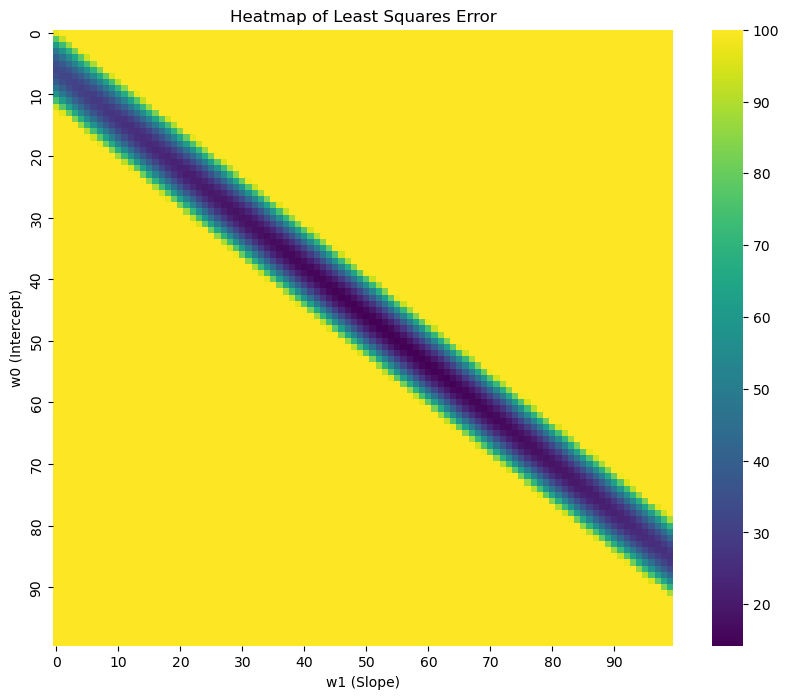

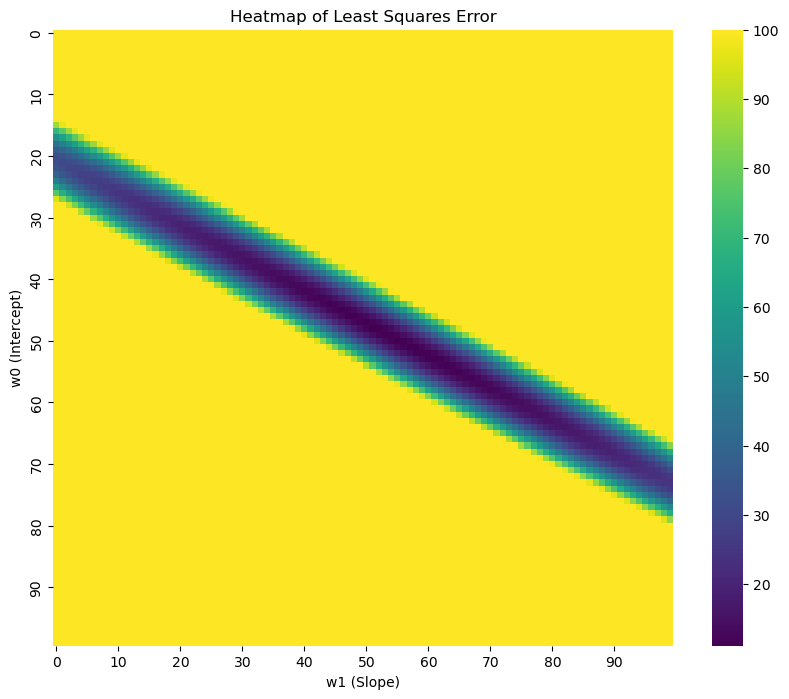

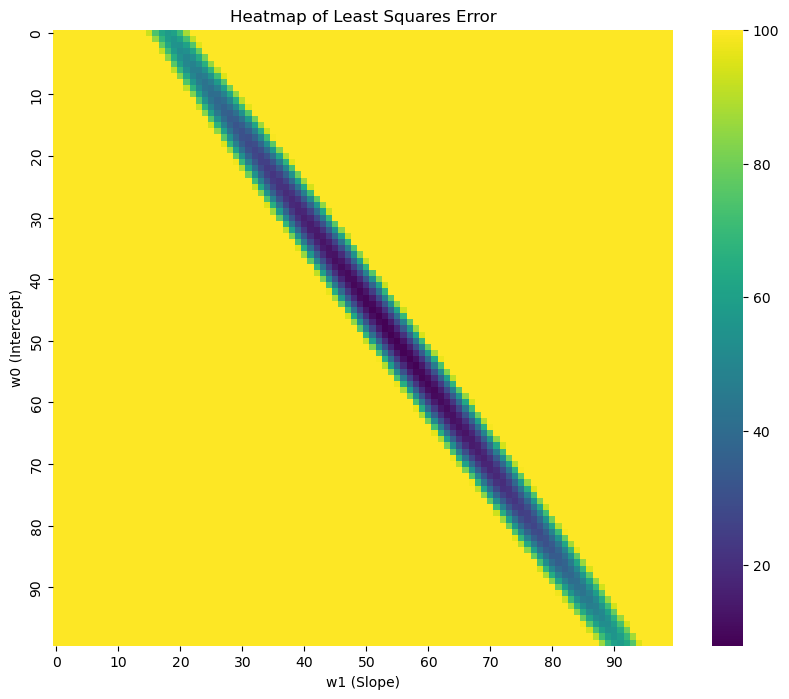

In [22]:
def liner_regretion_map(df, columnx, columny, a=10):
    if columnx not in df.columns or columny not in df.columns:
        print(f"Column {columnx} or {columny} not found in DataFrame.")
        return
    
    temp_df = df.dropna(subset=[f'{columnx}', f'{columny}','Date'])
    
    # Get the flow rate and discharge values as numpy arrays
    X = np.array(temp_df[f'{columnx}'], dtype=float)
    Y = np.array(temp_df[f'{columny}'], dtype=float)

    if a is not None:
        # Apply log(a) transformation to X
        Y = np.emath.logn((a + 1e-6),Y)
    
    w1, w0, r, p, err = stats.linregress(X, Y)

    # w0_range = np.linspace(w0*0.999, w0*1.001, 50)
    # w1_range = np.linspace(w1*0.99, w1*1.01, 50)

    w0_range = np.linspace(w0*0.25, w0*1.75, 100)
    w1_range = np.linspace(w1*-10, w1*10, 100)

    SLS_grid = np.zeros((len(w0_range), len(w1_range)))
    for i_idx, i in enumerate(w0_range):
        for j_idx, j in enumerate(w1_range):
            Y_predicted = j * X + i  # Perform element-wise multiplication
            Sum_of_least_squares = np.sum((Y - Y_predicted)**2)  # Corrected to **2 for exponentiation
            # Store the sum of least squares at the correct position in the 2D array
            SLS_grid[i_idx, j_idx] = Sum_of_least_squares
    
    plt.figure(figsize=(10, 8))
    sns.heatmap(SLS_grid, cmap='viridis', xticklabels=10, yticklabels=10, vmax=100)

    # Set axis labels
    plt.xlabel('w1 (Slope)')
    plt.ylabel('w0 (Intercept)')
    plt.title('Heatmap of Least Squares Error')

liner_regretion_map(local_dfs[0], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
liner_regretion_map(local_dfs[1], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
liner_regretion_map(local_dfs[2], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
liner_regretion_map(local_dfs[3], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
liner_regretion_map(local_dfs[4], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
liner_regretion_map(local_dfs[5], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')
liner_regretion_map(local_dfs[6], columnx='FlowRate (MGD)', columny='PMMoV (gc/ 100mL)')

In [23]:
# extractor performance metric
# isolate the residual value of each point

def local_residual_data_extractor(df, columnx, columny, a=10, codes=None):
    if columnx not in df.columns or columny not in df.columns:
        print(f"Column {columnx} or {columny} not found in DataFrame.")
        return

    # empty code failsafe
    if codes is None:
        codes = 'all'

    temp_df = df.dropna(subset=[f'{columnx}', f'{columny}','Date', codes])
    
    residuals_list = []
    
    grouped = temp_df.groupby(codes)
    
    for group_name, group_data in grouped:
        # Extract X and Y values for the current group
        X = np.array(group_data[columnx])
        Y = np.array(group_data[columny])

        # If 'a' is provided, apply log transformation to Y
        if a is not None:
            Y = np.emath.logn(a + 1e-6, Y)  # Ensure no log(0) by adding a small value to Y

        # Perform linear regression to get the slope (w1) and intercept (w0)
        w1, w0, r_value, p_value, std_err = stats.linregress(X.astype(float), Y.astype(float))
        
        # Calculate predicted values from the regression
        Y_predicted = w1 * X.astype(float) + w0
        
        # Calculate residuals (difference between actual and predicted values)
        residuals = Y - Y_predicted
        
        # Add residuals to the group data
        group_data['Log Residuals'] = residuals
        
        # Append the group with residuals back to the list
        residuals_list.append(group_data)
    
    # Concatenate all the groups back into a single DataFrame
    result_df = pd.concat(residuals_list, axis=0)
    
    # Return the new DataFrame with residuals added
    return result_df
    
df_filtered = local_residual_data_extractor(df_filtered, columnx = 'FlowRate (MGD)', columny = 'PMMoV (gc/ 100mL)', a=10, codes="Code")
df_filtered

Date Code    Mean CT  PMMoV (gc/ 100mL) FlowRate (MGD)    pH  \
11   2023-03-02   CS  27.268000       5.120000e+05          0.982  7.20   
12   2023-03-06   CS  28.455000       1.670000e+06          0.801  7.18   
13   2023-03-13   CS  28.600000       2.010000e+06           0.72  7.01   
14   2023-03-20   CS  27.847000       3.540000e+05           0.78  7.06   
15   2023-04-03   CS  29.635000       9.312425e+05           1.06  7.01   
...         ...  ...        ...                ...            ...   ...   
1136 2024-10-10   WY  27.994562       5.750000e+06         12.725   NaN   
1137 2024-10-14   WY  25.661060       1.150000e+07          12.01   NaN   
1138 2024-10-17   WY  29.169218       1.940000e+06         12.957   NaN   
1139 2024-10-21   WY  27.605030       5.620000e+06         11.563   NaN   
1140 2024-10-24   WY  26.915420       8.700000e+06         13.024   NaN   

               N1           N2            Pi6  PRCP (Rain fall in)  ...  \
11     720.000000   720.000000   20480.000000                 0.00  ...   
12    1788.800000  2516.800000   40560.000000                 0.41  ...   
13    1656.000000  1680.000000   75120.000000                 0.18  ...   
14    1756.266667  1716.800000  115242.666700                 0.00  ...   
15    3466.666667  3493.333333  145600.000000                 0.00  ...   
...           ...          ...            ...                  ...  ...   
1136  2880.000000     0.000000   12477.905580                 0.00  ...   
1137  4410.225363     0.000000   32965.626280                 0.42  ...   
1138  2160.000000     0.000000    4082.399369                 0.00  ...   
1139  2160.000000     0.000000   49437.037360                 0.00  ...   
1140  5930.585680     0.000000   19050.154250                 0.00  ...   

      SNWD (Snow Depth)  Discharge (ft^3/s)  Temp  sample type  \
11                    0                9380   9.8            G   
12                    1                8410   9.9            G   
13                    2                7600   9.8            G   
14                    0                7030   9.7            G   
15                    0               12700   9.6            G   
...                 ...                 ...   ...          ...   
1136                  0                1190  18.3            C   
1137                  0                1460  17.2            C   
1138                  0                1590  17.2            C   
1139                  0                1420  17.4            C   
1140                  0                1450  17.4            C   

     pellet volume ml  Extractor  qPCR Operator  Date tested Lag date  \
11                3.0         17             11          NaN      NaN   
12                3.5          1             11          NaN      NaN   
13                4.5          1             11          NaN      NaN   
14                3.7         17             11          NaN      NaN   
15                5.0          1             11          NaN      NaN   
...               ...        ...            ...          ...      ...   
1136             12.0          4              4   10/11/2024      1.0   
1137              4.9         10              6   10/16/2024      2.0   
1138              9.0          4              4   10/18/2024      1.0   
1139              9.0          6              6   10/23/2024      2.0   
1140              8.7          4              4   10/28/2024      4.0   

      Log Residuals  
11        -0.238575  
12         0.119886  
13         0.131008  
14        -0.571809  
15         0.088007  
...             ...  
1136      -0.107361  
1137       0.153198  
1138      -0.566095  
1139      -0.183065  
1140       0.089415  

[1048 rows x 21 columns]

In [24]:
df_filtered['Date'] = pd.to_datetime(df_filtered['Date'])
df_filtered["Day of Week"] = df_filtered['Date'].dt.weekday
df_filtered

Date Code    Mean CT  PMMoV (gc/ 100mL) FlowRate (MGD)    pH  \
11   2023-03-02   CS  27.268000       5.120000e+05          0.982  7.20   
12   2023-03-06   CS  28.455000       1.670000e+06          0.801  7.18   
13   2023-03-13   CS  28.600000       2.010000e+06           0.72  7.01   
14   2023-03-20   CS  27.847000       3.540000e+05           0.78  7.06   
15   2023-04-03   CS  29.635000       9.312425e+05           1.06  7.01   
...         ...  ...        ...                ...            ...   ...   
1136 2024-10-10   WY  27.994562       5.750000e+06         12.725   NaN   
1137 2024-10-14   WY  25.661060       1.150000e+07          12.01   NaN   
1138 2024-10-17   WY  29.169218       1.940000e+06         12.957   NaN   
1139 2024-10-21   WY  27.605030       5.620000e+06         11.563   NaN   
1140 2024-10-24   WY  26.915420       8.700000e+06         13.024   NaN   

               N1           N2            Pi6  PRCP (Rain fall in)  ...  \
11     720.000000   720.000000   20480.000000                 0.00  ...   
12    1788.800000  2516.800000   40560.000000                 0.41  ...   
13    1656.000000  1680.000000   75120.000000                 0.18  ...   
14    1756.266667  1716.800000  115242.666700                 0.00  ...   
15    3466.666667  3493.333333  145600.000000                 0.00  ...   
...           ...          ...            ...                  ...  ...   
1136  2880.000000     0.000000   12477.905580                 0.00  ...   
1137  4410.225363     0.000000   32965.626280                 0.42  ...   
1138  2160.000000     0.000000    4082.399369                 0.00  ...   
1139  2160.000000     0.000000   49437.037360                 0.00  ...   
1140  5930.585680     0.000000   19050.154250                 0.00  ...   

      Discharge (ft^3/s)  Temp  sample type  pellet volume ml Extractor  \
11                  9380   9.8            G               3.0        17   
12                  8410   9.9            G               3.5         1   
13                  7600   9.8            G               4.5         1   
14                  7030   9.7            G               3.7        17   
15                 12700   9.6            G               5.0         1   
...                  ...   ...          ...               ...       ...   
1136                1190  18.3            C              12.0         4   
1137                1460  17.2            C               4.9        10   
1138                1590  17.2            C               9.0         4   
1139                1420  17.4            C               9.0         6   
1140                1450  17.4            C               8.7         4   

      qPCR Operator  Date tested  Lag date Log Residuals  Day of Week  
11               11          NaN       NaN     -0.238575            3  
12               11          NaN       NaN      0.119886            0  
13               11          NaN       NaN      0.131008            0  
14               11          NaN       NaN     -0.571809            0  
15               11          NaN       NaN      0.088007            0  
...             ...          ...       ...           ...          ...  
1136              4   10/11/2024       1.0     -0.107361            3  
1137              6   10/16/2024       2.0      0.153198            0  
1138              4   10/18/2024       1.0     -0.566095            3  
1139              6   10/23/2024       2.0     -0.183065            0  
1140              4   10/28/2024       4.0      0.089415            3  

[1048 rows x 22 columns]

Extractor
0      64
1     136
2       3
3       3
4      18
5      81
6      52
7      10
8      10
9       6
10    103
11     12
12     15
13    138
14      6
15      1
16     32
17    358
dtype: int64


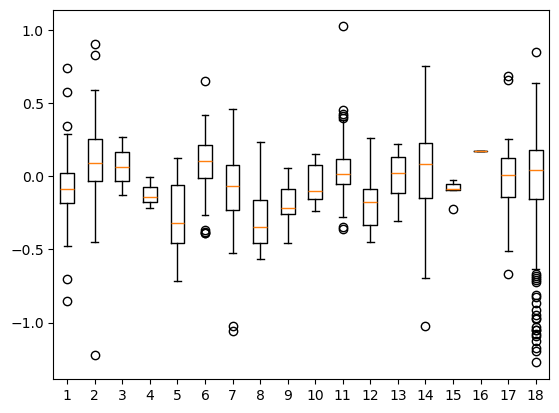

In [25]:
grouped_data = df_filtered.groupby('Extractor')['Log Residuals'].apply(list)
plt.boxplot(grouped_data)
print(df_filtered.groupby('Extractor').size())

{'whiskers': [<matplotlib.lines.Line2D at 0x1b47349eb70>,
 'caps': [<matplotlib.lines.Line2D at 0x1b47345a3c0>,
 'boxes': [<matplotlib.lines.Line2D at 0x1b47349ecf0>,
 'medians': [<matplotlib.lines.Line2D at 0x1b47345b200>,
 'fliers': [<matplotlib.lines.Line2D at 0x1b47345a120>,
 'means': []}

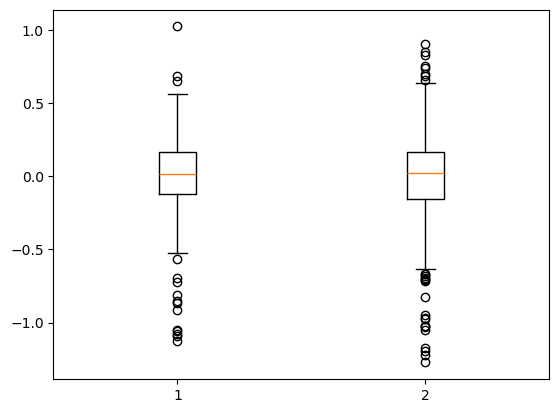

In [26]:
grouped_data = df_filtered.groupby('sample type')['Log Residuals'].apply(list)
plt.boxplot(grouped_data)

In [27]:
px.scatter(df_filtered, 
           title = 'Extractor Performance Time Dependence',
           x=df_filtered['Date'], 
           y=df_filtered['Log Residuals'],
           color = df_filtered['Extractor'],
           color_continuous_scale="sunsetdark",
           render_mode='svg')

In [28]:
# update splits to add residuals to local df
splits = list(df_filtered.groupby("Code")) 
  
# # view splitted dataframe 
# print(splits[5][1])

# CS
CS_df = splits[0][1]
CS_df = CS_df.reset_index()
CS_df = CS_df.drop(columns = ['index'])

# GG
GG_df = splits[1][1]
GG_df = GG_df.reset_index()
GG_df = GG_df.drop(columns = ['index'])

# GO
GO_df = splits[2][1]
GO_df = GO_df.reset_index()
GO_df = GO_df.drop(columns = ['index'])

# GR
GR_df = splits[3][1]
GR_df = GR_df.reset_index()
GR_df = GR_df.drop(columns = ['index'])

# WB
WB_df = splits[4][1]
WB_df = WB_df.reset_index()
WB_df = WB_df.drop(columns = ['index'])

# WK
WK_df = splits[5][1]
WK_df = WK_df.reset_index()
WK_df = WK_df.drop(columns = ['index'])

# WY
WY_df = splits[6][1]
WY_df = WY_df.reset_index()
WY_df = WY_df.drop(columns = ['index'])

local_dfs = [CS_df,GG_df, GO_df, GR_df, WB_df, WK_df, WY_df]
local_dfs[1]

Date Code    Mean CT  PMMoV (gc/ 100mL) FlowRate (MGD)  pH  \
0   2023-03-02   GG  28.867000         215000.000          3.154 NaN   
1   2023-03-06   GG  27.144000        5480000.000           3.14 NaN   
2   2023-03-13   GG  27.100000        4690000.000          2.498 NaN   
3   2023-03-20   GG  27.129000         857000.000            1.8 NaN   
4   2023-04-03   GG  28.785000        1716828.741         4.1991 NaN   
..         ...  ...        ...                ...            ...  ..   
147 2024-10-10   GG  28.869354        2110000.000         1.6002 NaN   
148 2024-10-14   GG  26.179660        5780000.000          1.826 NaN   
149 2024-10-17   GG  28.400034        2000000.000         1.8363 NaN   
150 2024-10-21   GG  28.270570        2540000.000         1.8108 NaN   
151 2024-10-24   GG  27.809560        3260000.000         1.7868 NaN   

              N1           N2            Pi6  PRCP (Rain fall in)  ...  \
0    2314.666667  1792.000000    7466.666667                 0.00  ...   
1    4460.800000  3300.266667   38624.000000                 0.41  ...   
2    2368.000000  2816.000000   74240.000000                 0.18  ...   
3    1670.400000  1468.800000  214848.000000                 0.00  ...   
4    4492.800000  3859.200000  165312.000000                 0.00  ...   
..           ...          ...            ...                  ...  ...   
147  1920.000000     0.000000    8363.883872                 0.00  ...   
148  2215.590674     0.000000   18854.591930                 0.42  ...   
149  1320.000000     0.000000    6187.561544                 0.00  ...   
150  1536.000000     0.000000   30325.878910                 0.00  ...   
151  3837.209320     0.000000   14015.083920                 0.00  ...   

     Discharge (ft^3/s)  Temp  sample type  pellet volume ml Extractor  \
0                  9380   9.8            C               3.5        17   
1                  8410   9.9            C               4.8         1   
2                  7600   9.8            C               4.0         1   
3                  7030   9.7            C               5.4        17   
4                 12700   9.6            C               5.4         1   
..                  ...   ...          ...               ...       ...   
147                1190  18.3            C               8.0         4   
148                1460  17.2            C               3.5        10   
149                1590  17.2            C               5.5         4   
150                1420  17.4            C               6.4         6   
151                1450  17.4            C               6.0         4   

     qPCR Operator  Date tested  Lag date Log Residuals  Day of Week  
0               11          NaN       NaN     -1.081681            3  
1               11          NaN       NaN      0.322418            0  
2               11          NaN       NaN      0.151936            0  
3               11          NaN       NaN     -0.698102            0  
4               11          NaN       NaN     -0.011927            0  
..             ...          ...       ...           ...          ...  
147              4   10/11/2024       1.0     -0.338816            3  
148              6   10/16/2024       2.0      0.135011            0  
149              4   10/18/2024       1.0     -0.324236            3  
150              6   10/23/2024       2.0     -0.224519            0  
151              4   10/28/2024       4.0     -0.119981            3  

[152 rows x 22 columns]

<Figure size 1200x1000 with 0 Axes>

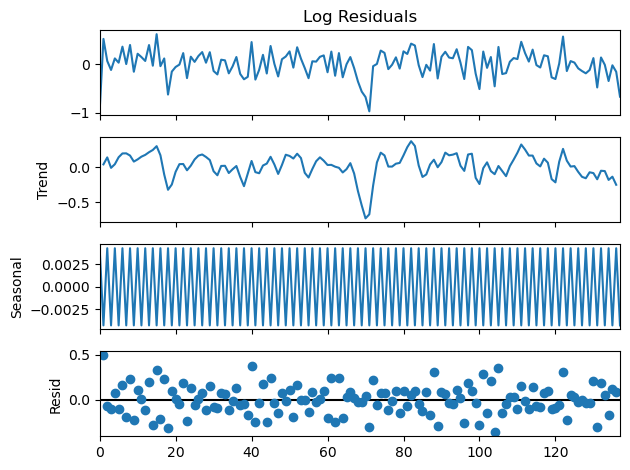

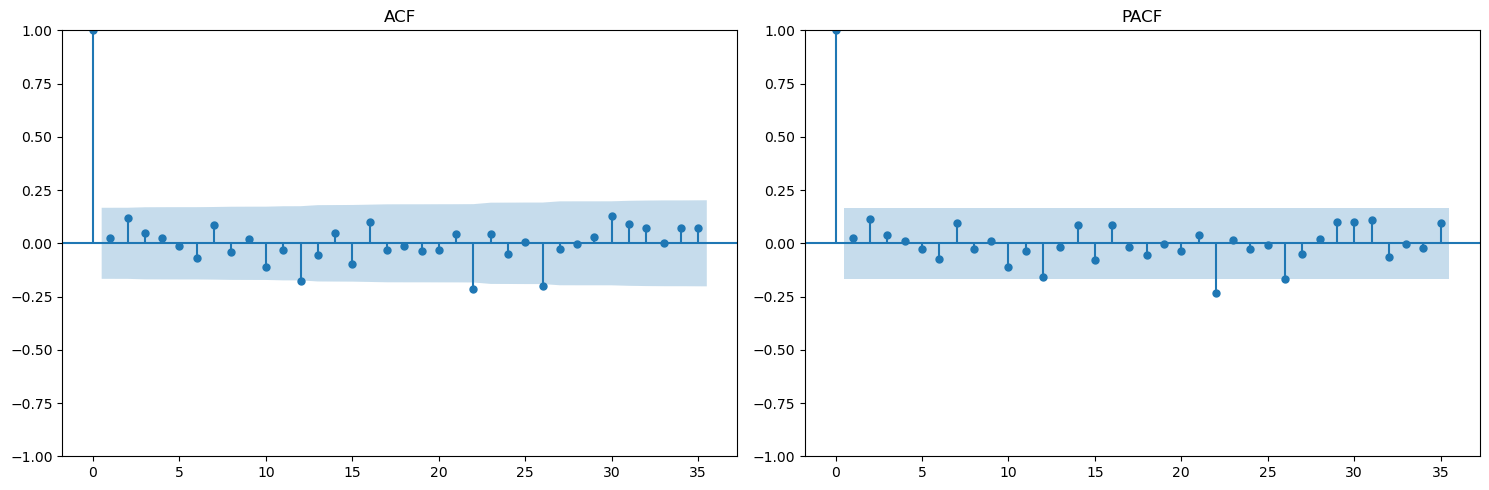

In [29]:
#AR(P) on the residuals
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.seasonal import seasonal_decompose

df = local_dfs[5]
df
train_size = len(df['Log Residuals']) - 8 # -1 month
train = df['Log Residuals'][:train_size]
test = df['Log Residuals'][train_size:]

plt.figure(figsize=(12, 6))
plt.plot(train.index, train.values, label="Training Data")
plt.plot(test.index, test.values, label="Test Data")
plt.legend()
plt.title("Temperature Time Series")
plt.show()

# STL Decomposition
decomposition = seasonal_decompose(train, period=2)
plt.figure(figsize=(12, 10))
decomposition.plot()
plt.tight_layout()
plt.show()

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

plot_acf(train, lags=35, alpha=0.05, ax=ax1)
ax1.set_title('ACF')

plot_pacf(train, lags=35, alpha=0.05, ax=ax2)
ax2.set_title('PACF')

plt.tight_layout()
plt.show()

In [30]:
px.scatter(local_dfs[3], 
           title = 'Local day of week residuals',
           x=local_dfs[3]['Date'], 
           y=local_dfs[3]['Log Residuals'],
           color = local_dfs[3]['Day of Week'],
           color_continuous_scale="sunsetdark",
           render_mode='svg')

## Notes ##
looking at the data and the fits of data with available variables, only flow rate works as a general model to use for a general model on all sites. Flow rate, in geneal, lowers the amount of PMMoV recover.

In [31]:
px.scatter(df_filtered, 
           title = 'Local day of week residuals',
           x=df_filtered['Date'], 
           y=df_filtered['N1'],
           color = df_filtered['Code'],
           render_mode='svg')

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = 3.3671e+03
Predicted Intercept w0 = 5.3796e+03
Person correlation r 1.5884e-01
square sum of residuals = 5.7190e+09


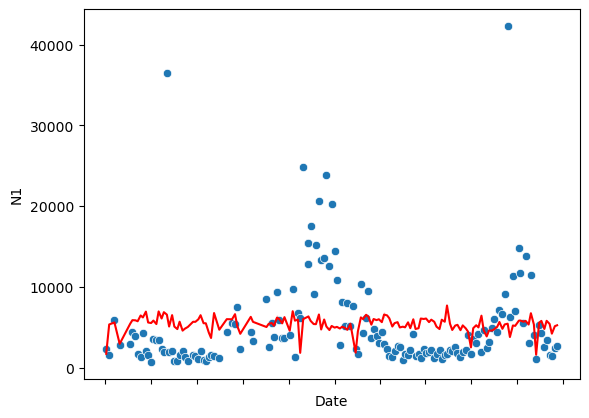

In [32]:
univariate_regress(local_dfs[3],columnx='Log Residuals', columny='N1')

In [ ]:
file_path = r'C:\Users\jackz\Documents\Homework\Data Sciance\830\Project 2\USA_COVID-19_Deaths'

COVID_df = pd.read_csv(file_path)
COVID_df['Date'] = pd.to_datetime(COVID_df['Date'])
df_COVID = df_filtered.merge(COVID_df, how='inner', on='Date')
# df_COVID
# df_COVID.to_csv('Wastewater data sheet', index=False)

Csplits = list(df_COVID.groupby("Code")) 
# # view splitted dataframe 
# print(splits[5][1])

# CS
CCS_df = Csplits[0][1]

# GG
CGG_df = Csplits[1][1]

# GO
CGO_df = Csplits[2][1]

# GR
CGR_df = Csplits[3][1]

# WB
CWB_df = Csplits[4][1]

# WK
CWK_df = Csplits[5][1]

# WY
CWY_df = Csplits[6][1]

Clocal_dfs = [CCS_df, CGG_df, CGO_df, CGR_df, CWB_df, CWK_df, CWY_df]
Clocal_dfs[3]

Date Code    Mean CT  PMMoV (gc/ 100mL) FlowRate (MGD)  pH  \
445 2023-03-02   GR  28.554000         270000.000          51.58 NaN   
446 2023-03-06   GR  28.041000        3460000.000         48.747 NaN   
447 2023-03-13   GR  27.600000        3920000.000           50.8 NaN   
448 2023-03-20   GR  27.192000         759000.000         43.659 NaN   
449 2023-04-03   GR  28.109000        2188997.082           70.5 NaN   
..         ...  ...        ...                ...            ...  ..   
599 2024-10-10   GR  26.936539        7390000.000           29.9 NaN   
600 2024-10-14   GR  27.136640        5500000.000           31.2 NaN   
601 2024-10-17   GR  28.232552        2450000.000           30.6 NaN   
602 2024-10-21   GR  27.082280        3930000.000           37.4 NaN   
603 2024-10-24   GR  27.244150        4240000.000           37.4 NaN   

              N1           N2            Pi6  PRCP (Rain fall in)  ...  Temp  \
445  2304.000000  2707.200000   14208.000000                 0.00  ...   9.8   
446  1601.600000  1768.000000   26416.000000                 0.41  ...   9.9   
447  5880.000000  6432.000000  101040.000000                 0.18  ...   9.8   
448  2853.333333  2773.333333  166133.333300                 0.00  ...   9.7   
449  2904.000000  3480.000000  141840.000000                 0.00  ...   9.6   
..           ...          ...            ...                  ...  ...   ...   
599  3391.970825     0.000000    7310.417748                 0.00  ...  18.3   
600  1536.000000     0.000000   26918.604170                 0.42  ...  17.2   
601  1440.000000     0.000000    6947.456969                 0.00  ...  17.2   
602  2410.384176     0.000000   24106.300370                 0.00  ...  17.4   
603  2632.180082     0.000000   15557.755780                 0.00  ...  17.4   

     sample type  pellet volume ml  Extractor qPCR Operator  Date tested  \
445            C               3.6         17            11          NaN   
446            C               5.5          1            11          NaN   
447            C               4.5          1            11          NaN   
448            C               5.0         17            11          NaN   
449            C               4.5          1            11          NaN   
..           ...               ...        ...           ...          ...   
599            G               7.5          4             4   10/11/2024   
600            C               6.4         10             6   10/16/2024   
601            C               6.0          4             4   10/18/2024   
602            C               4.4          6             6   10/23/2024   
603            C               5.3          4             4   10/28/2024   

     Lag date  Log Residuals Day of Week  BiWeekly Deaths  
445       NaN      -1.092121           3           1076.5  
446       NaN      -0.013691           0           1000.0  
447       NaN       0.061739           0            924.5  
448       NaN      -0.725115           0            880.5  
449       NaN       0.012318           0            724.5  
..        ...            ...         ...              ...  
599       1.0       0.121074           3            477.5  
600       2.0       0.006229           0            396.5  
601       1.0      -0.351169           3            396.5  
602       2.0      -0.075657           0            353.0  
603       4.0      -0.042684           3            353.0  

[159 rows x 23 columns]

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [11.96095361]
Predicted Intercept w0 = 1.4527e+03
sum of residuals = 2.6395e+11


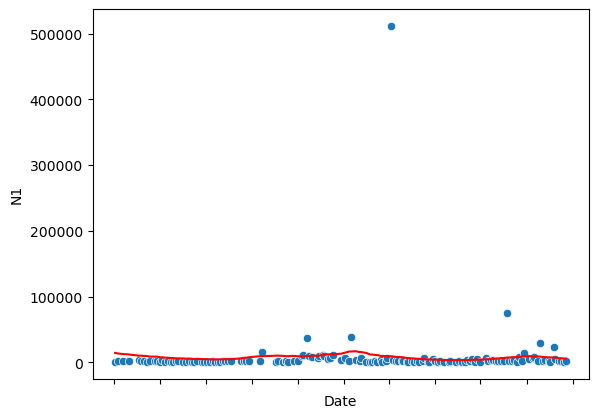

Predicted vs Imputed results for ['CS']:
Predicted Slope (weights) = [1.35540658e+01 1.20575013e-03]
Predicted Intercept w0 = -2.7496e+03
sum of residuals = 2.6321e+11


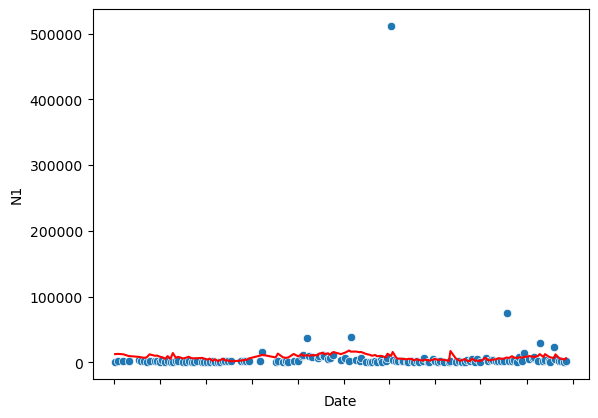

In [34]:
mutivariate_regress(Clocal_dfs[0],columnx=['BiWeekly Deaths'], columny="N1")
mutivariate_regress(Clocal_dfs[0],columnx=['BiWeekly Deaths','PMMoV (gc/ 100mL)'], columny='N1')

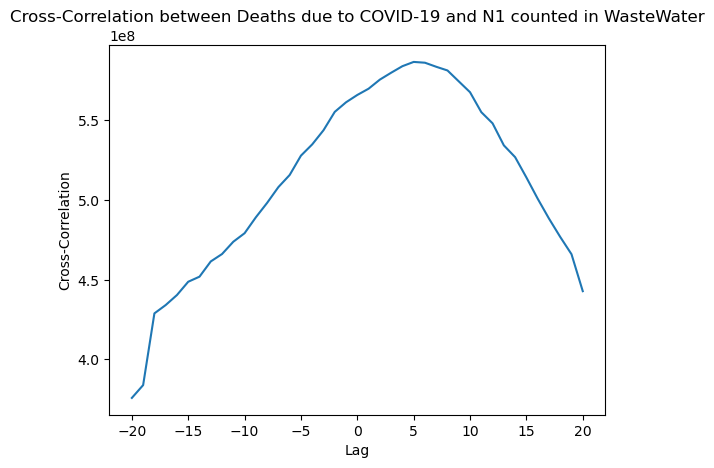

The optimal lag p is: 5


Text(0.5, 1.0, 'BiWeekly Deaths and N1 Lagged vs. Date')

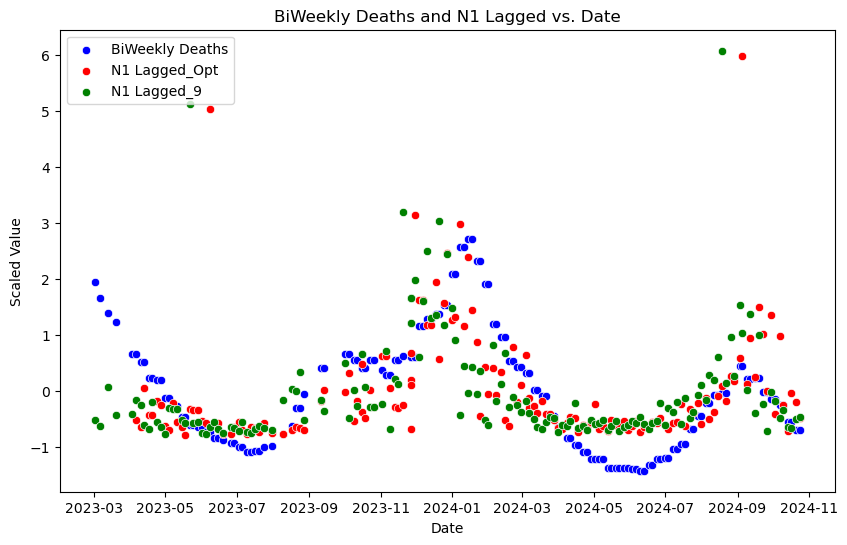

In [ ]:
Cdf = Clocal_dfs[3]
Cdf

max_lag = 20

# Compute the cross-correlation between Y and X at different lags
cross_corr = np.correlate(Cdf['BiWeekly Deaths'], Cdf['N1'], mode='full')
lags = np.arange(-max_lag, max_lag + 1)

start_idx = len(Cdf) - 1 - max_lag
end_idx = len(Cdf) - 1 + max_lag + 1
cross_corr_lagged = cross_corr[start_idx:end_idx]

# Plot the cross-correlation
plt.plot(lags, cross_corr_lagged)
plt.xlabel('Lag')
plt.ylabel('Cross-Correlation')
plt.title('Cross-Correlation between Deaths due to COVID-19 and N1 counted in WasteWater')
plt.show()

# Find the optimal lag p
optimal_p = lags[np.argmax(cross_corr_lagged)]
print(f"The optimal lag p is: {optimal_p}")\

Cdf['N1_Lagged'] = Cdf['N1'].shift(optimal_p)
Cdf['N1_Lagged9'] = Cdf['N1'].shift(9)
Cdf['FlowRate_Lagged (MGD)'] = Cdf['FlowRate (MGD)'].shift(optimal_p)
scaler = StandardScaler()

# Fit and transform the 'BiWeekly Deaths' and 'N1_Lagged' columns
Cdf['BiWeekly Deaths_scaled'] = scaler.fit_transform(Cdf[['BiWeekly Deaths']])
Cdf['N1_Lagged_scaled'] = scaler.fit_transform(Cdf[['N1_Lagged']])
Cdf['N1_Lagged9_scaled'] = scaler.fit_transform(Cdf[['N1_Lagged9']])

# Create the scatter plot
plt.figure(figsize=(10, 6))

# Plot the 'BiWeekly Deaths' (scaled) vs. 'Date'
sns.scatterplot(x=Cdf['Date'], y=Cdf['BiWeekly Deaths_scaled'], label='BiWeekly Deaths', color='blue')

# Plot the 'N1_Lagged' (scaled) vs. 'Date'
sns.scatterplot(x=Cdf['Date'], y=Cdf['N1_Lagged_scaled'], label='N1 Lagged_Opt', color='red')

sns.scatterplot(x=Cdf['Date'], y=Cdf['N1_Lagged9_scaled'], label='N1 Lagged_9', color='green')
# Adding labels and title
plt.xlabel('Date')
plt.ylabel('Scaled Value')
plt.title('BiWeekly Deaths and N1 Lagged vs. Date')

Shuffling through lags gives wildly different lags for each site. the suspected cause for the difference in lags is how flow rate affects N1 N2 counts. the true lag time for all if not Most site should be 9 or 10 Ps which is roughly 4-5 Weeks advanced notice.
Steps needed to complete this work.
* Accurate local COVID-19 Infection, hospitalization, or death data
* More knowledge on how to create data to fit liner regression models to data with adjustable means
Questions explored.
* What environmental factors affect PMMoV detection
* What are potential reasons for outliers in PMMoV
* Are there differences between grab and composite sample collection
* Is there an internal laboratory component affecting the variation of data. 
Questions Raised by the analysis of present data
* What is the accuracy of our data?
    * Can the noise in PMMoV data be explained by some unexplored external or internal factor, or is it the accuracy limited by the method.
    * Is it possible to predict what the true PMMoV of a collected sample should be through a RBF or bayesian regression
* Dose PMMoV detection have seasonality
    * We to see if PMMoV had any time correlations through ACF and PACF functions We found no time corelation in our Bi-weekly data
    * A time corelation for PMMoV could exist but our P would need to be less than 0, indicating the need for more frequent testing to find A possible time correlation
* Why do some sites PMMoV ratings correlate better with flowrate and others precipitation
    * We have a working theory that composite sample PMMoV correlates well with flow rate and grab samples correlate well with precipitation, but this is not always true.
    * What conditions have to be met for samples to correlate well with one environmental factor over the other

C:\Users\jackz\AppData\Local\Temp\ipykernel_11532\2991170789.py:4: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jackz\AppData\Local\Temp\ipykernel_11532\2991170789.py:5: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy

C:\Users\jackz\AppData\Local\Temp\ipykernel_11532\2991170789.py:6: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/panda

RMSE for N1 Opt lag: 43.36923978392866
RMSE for N1 9 lag: 31.0310564965651


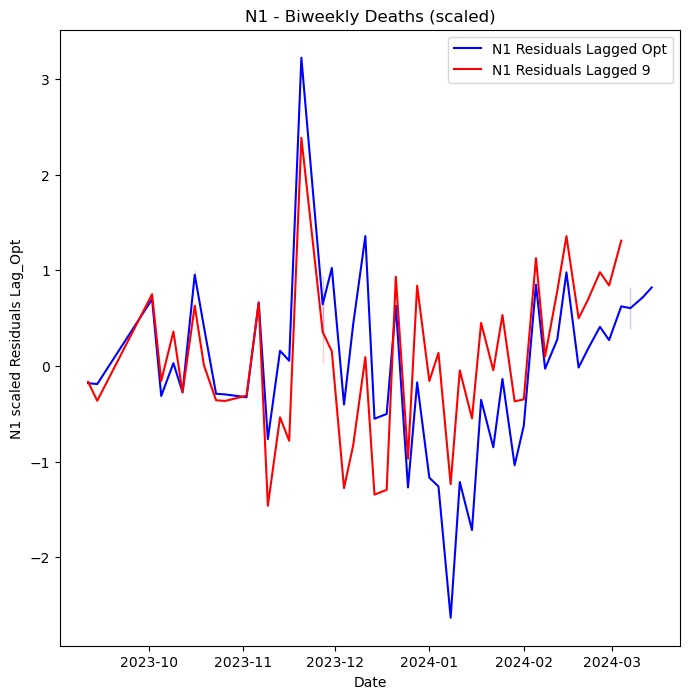

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = 5.1689e-01
Predicted Intercept w0 = -1.0506e-03
Person correlation r 4.4926e-01
square sum of residuals = 4.5651e+01


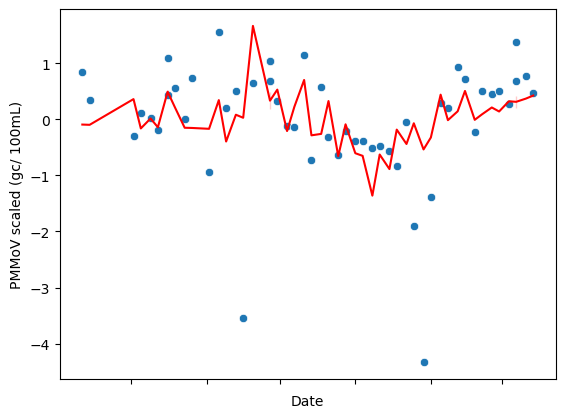

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = -1.2671e-01
Predicted Intercept w0 = -1.7349e-02
Person correlation r -1.1064e-01
square sum of residuals = 5.5978e+01


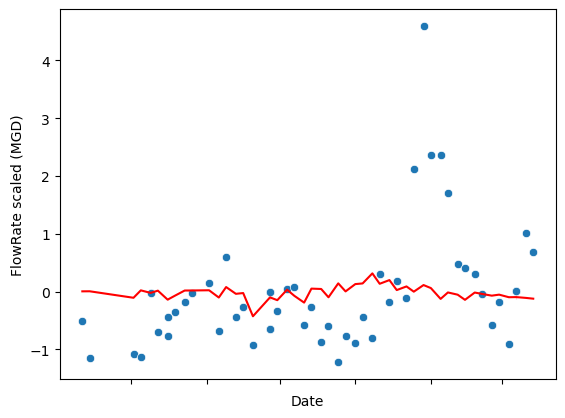

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = 4.0722e-01
Predicted Intercept w0 = -7.4191e-02
Person correlation r 3.0674e-01
square sum of residuals = 4.8911e+01


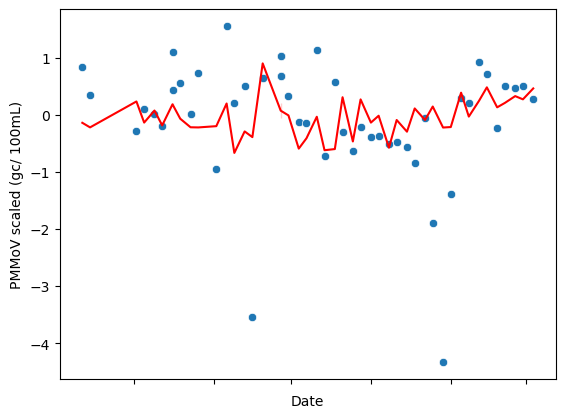

Predicted vs Imputed results for ['GR']:
Predicted Slope w1 = -4.3918e-02
Predicted Intercept w0 = -5.7640e-02
Person correlation r -3.2772e-02
square sum of residuals = 5.4953e+01


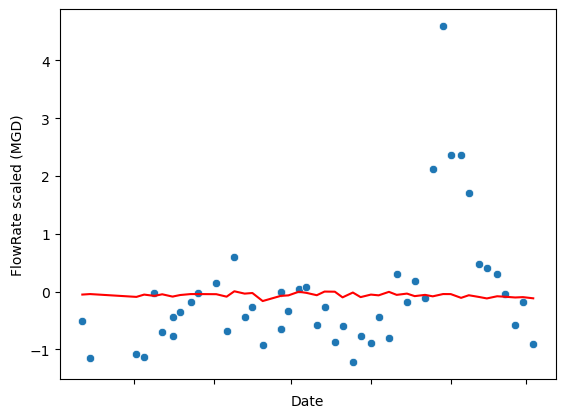

In [79]:
accuracy_test_df = Clocal_dfs[3]
accuracy_test_df = accuracy_test_df.loc[(accuracy_test_df['Date'] >= '2023-09-01') & (accuracy_test_df['Date'] <= '2024-04-01')]

accuracy_test_df['BiWeekly Deaths scaled'] = scaler.fit_transform(accuracy_test_df[['BiWeekly Deaths']])
accuracy_test_df['N1 Lagged scaled'] = scaler.fit_transform(accuracy_test_df[['N1']])
accuracy_test_df['FlowRate scaled (MGD)'] = scaler.fit_transform(accuracy_test_df[['FlowRate (MGD)']])
accuracy_test_df['PMMoV scaled (gc/ 100mL)'] = scaler.fit_transform(np.log10(accuracy_test_df[['PMMoV (gc/ 100mL)']]))
accuracy_test_df['BiWeekly Deaths scaled Opt'] = accuracy_test_df['BiWeekly Deaths scaled'].shift(-5)
accuracy_test_df['BiWeekly Deaths scaled 9'] = accuracy_test_df['BiWeekly Deaths scaled'].shift(-9)

accuracy_test_df['N1 scaled Residuals Lag_Opt'] = accuracy_test_df['N1 Lagged scaled']-accuracy_test_df['BiWeekly Deaths scaled Opt']
accuracy_test_df['N1 scaled Residuals Lag_9'] = accuracy_test_df['N1 Lagged scaled']-accuracy_test_df['BiWeekly Deaths scaled 9']
accuracy_test_df['N1 flowrate scaled Residuals Lag_Opt'] = accuracy_test_df['N1 scaled Residuals Lag_9'] + accuracy_test_df['FlowRate scaled (MGD)']
accuracy_test_df['N1 flowrate scaled Residuals Lag_9'] = accuracy_test_df['N1 scaled Residuals Lag_Opt'] + accuracy_test_df['FlowRate scaled (MGD)']
accuracy_test_df['N1 PMMoV scaled Residuals Lag_Opt'] = accuracy_test_df['N1 scaled Residuals Lag_9'] - accuracy_test_df['PMMoV scaled (gc/ 100mL)']
accuracy_test_df['N1 PMMoV scaled Residuals Lag_9'] = accuracy_test_df['N1 scaled Residuals Lag_Opt'] - accuracy_test_df['PMMoV scaled (gc/ 100mL)']

SSE_N1_Opt =(accuracy_test_df['N1 scaled Residuals Lag_Opt']**2).sum()
SSE_N1_9 =(accuracy_test_df['N1 scaled Residuals Lag_9']**2).sum()
RMSE_N1_Opt = np.sqrt((accuracy_test_df['N1 scaled Residuals Lag_Opt']**2).mean())
RMSE_N1_9 = np.sqrt((accuracy_test_df['N1 scaled Residuals Lag_9']**2).mean())
RMSE_N1_flow_Opt = np.sqrt((accuracy_test_df['N1 flowrate scaled Residuals Lag_Opt']**2).mean())
RMSE_N1_flow_9 = np.sqrt((accuracy_test_df['N1 flowrate scaled Residuals Lag_9']**2).mean())
RMSE_N1_PMMoV_Opt = np.sqrt((accuracy_test_df['N1 PMMoV scaled Residuals Lag_Opt']**2).mean())
RMSE_N1_PMMoV_9 = np.sqrt((accuracy_test_df['N1 PMMoV scaled Residuals Lag_9']**2).mean())

print(f'RMSE for N1 Opt lag: {SSE_N1_Opt}')
print(f'RMSE for N1 9 lag: {SSE_N1_9}')
plt.figure(figsize=(8,8))
sns.lineplot(x=Cdf['Date'], y=accuracy_test_df['N1 scaled Residuals Lag_Opt'], label='N1 Residuals Lagged Opt', color='blue')
sns.lineplot(x=Cdf['Date'], y=accuracy_test_df['N1 scaled Residuals Lag_9'], label='N1 Residuals Lagged 9', color='red')
plt.title('N1 - Biweekly Deaths (scaled)')
plt.show()

univariate_regress(accuracy_test_df, columnx='N1 scaled Residuals Lag_Opt', columny='PMMoV scaled (gc/ 100mL)')
univariate_regress(accuracy_test_df, columnx='N1 scaled Residuals Lag_Opt', columny='FlowRate scaled (MGD)')
univariate_regress(accuracy_test_df, columnx='N1 scaled Residuals Lag_9', columny='PMMoV scaled (gc/ 100mL)')
univariate_regress(accuracy_test_df, columnx='N1 scaled Residuals Lag_9', columny='FlowRate scaled (MGD)')
# print(f'RMSE for N1 - flowrate Opt lag: {RMSE_N1_flow_Opt}')
# print(f'RMSE for N1 - floweate 9 lag: {RMSE_N1_flow_9}')
# plt.figure(figsize=(8,8))
# sns.lineplot(x=Cdf['Date'], y=accuracy_test_df['N1 flowrate scaled Residuals Lag_Opt'], label='N1 Residuals Lagged Opt', color='blue')
# sns.lineplot(x=Cdf['Date'], y=accuracy_test_df['N1 flowrate scaled Residuals Lag_9'], label='N1 Residuals Lagged 9', color='red')
# plt.title('N1 - (Biweekly Deaths + Flow rate)(scaled)')
# plt.show()

# print(f'RMSE for N1 - log10(PMMoV) Opt lag: {RMSE_N1_PMMoV_Opt}')
# print(f'RMSE for N1 - log10(PMMoV) 9 lag: {RMSE_N1_PMMoV_9}')
# plt.figure(figsize=(8,8))
# sns.lineplot(x=Cdf['Date'], y=accuracy_test_df['N1 PMMoV scaled Residuals Lag_Opt'], label='N1 Residuals Lagged Opt', color='blue')
# sns.lineplot(x=Cdf['Date'], y=accuracy_test_df['N1 PMMoV scaled Residuals Lag_9'], label='N1 Residuals Lagged 9', color='red')
# plt.title('N1 - (Biweekly Deaths + PMMoV)(scaled)')
# plt.show()